In [484]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay,RocCurveDisplay, precision_recall_curve,roc_curve,roc_auc_score

### Load the Datasets nadmerge for CLV

MERGE the holdout and main Datasets in order to have the same preparation before the splitting, we assign a new column in order to identify them later and split them.

In [485]:
df_all=pd.read_csv('/Users/mario/Desktop/Cell2Cell Dataset/cell2celltrain.csv')
features=pd.read_excel("/Users/mario/Desktop/ThesisCode/dictionary.xlsx")

# Load the holdout dataset
df_holdout = pd.read_csv('/Users/mario/Desktop/Cell2Cell Dataset/cell2cellholdout.csv')

#Add a marker column to each DataFrame in case you want to merge the 2 datasets to be able to separate them
df_all['dataset'] = 'train'
df_holdout['dataset'] = 'holdout'


#Merge the DataFrames
df = pd.concat([df_all, df_holdout], ignore_index=True)
df_all = df
# Lifetime Value Generation from R = Discount and Retention rate
r = 0.1 # discount rate 
Retention_Rate = 0.96 # Retention rate of Cell2Cell was 96% for the period of this dataset, the retention rate of our dataset is 72% for calibration reasons
df_all['CLV'] = df_all['MonthlyRevenue'] * df_all['MonthsInService'] * (1 + r) / (1 + r - Retention_Rate)
#df_holdout['CLV'] = df_holdout['MonthlyRevenue'] * df_holdout['MonthsInService'] * (1 + r) / (1 + r - Retention_Rate)

### Examine the missing values but not handling them yet.

In [486]:
def DataFrameInfo(df):
    variable_name_list=[]
    total_entry_list=[]
    data_dype_list=[]
    unique_value_list=[]
    nunique_value_list=[]
    missing_value_list=[]
    missing_value_rate_list=[]
    
    mean_list=[]
    median_list=[]
    min_list=[]
    max_list=[]
    
    for i in df.columns:
        variable_name_list.append(i)
        total_entry_list.append(df[i].count())
        data_dype_list.append(df[i].dtype)
        unique_value_list.append(list(df[i].unique()))
        nunique_value_list.append(df[i].nunique())
        missing_value_list.append(df[i].isnull().sum())
        missing_value_rate_list.append(np.round((100*df[i].isnull().sum())/(df[i].shape[0]),4))
        
        if df[i].dtype in ["float64","int64"]:
            mean_list.append(np.round(df[i].mean(),2))
            median_list.append(np.round(df[i].median(),2))
            min_list.append(df[i].min())
            max_list.append(df[i].max())
        else:
            mean_list.append(np.NaN)
            median_list.append(np.NaN)
            min_list.append(np.NaN)
            max_list.append(np.NaN)
            
        
        
        df_info_data=pd.DataFrame({"Variable_Name":variable_name_list,
                               "Type":data_dype_list,
                               "Total_Entry":total_entry_list,
                               "Missing_Value":missing_value_list,
                               "Missing_Value_Rate":missing_value_rate_list,
                               "Unique_Values":unique_value_list,
                               "Nunique_Values":nunique_value_list,
                               "Mean":mean_list,
                               "Median":median_list,
                               "Min":min_list,
                               "Max":max_list})

    return df_info_data

In [455]:
df_info=DataFrameInfo(df_all)

Load the Details Created in the Dictionary for the Classes/Types of each Variable

In [456]:
# Load excel file dictionary created with type of each variable for mapping
df_detail=pd.read_excel("dictionary.xlsx")
df_detail=df_detail.iloc[:,-1]

#Add the Variable Type as a new collumn to the DF Info
df_info=pd.concat([df_info,df_detail],axis=1)

In [457]:
# Create a copy of df_info to sort descending by Missing Value
df_info_copy=df_info.copy()
df_info_copy.index=df_info["Variable_Name"]
df_info_copy.sort_values("Missing_Value",ascending=False,inplace=True)

# Plot the missing values and the Rate 
cm = sns.light_palette("red", as_cmap=True)
df_info_missing_value = df_info_copy[["Missing_Value_Rate","Missing_Value"]].style.background_gradient(cmap=cm)
df_info_missing_value

,Missing_Value_Rate,Missing_Value
Variable_Name,,
Churn,28.150400,20000
AgeHH1,1.751000,1244
AgeHH2,1.751000,1244
PercChangeRevenues,0.706600,502
PercChangeMinutes,0.706600,502
RoamingCalls,0.304000,216
CLV,0.304000,216
OverageMinutes,0.304000,216
TotalRecurringCharge,0.304000,216


In [368]:
# Create a new column 'unknown_count' that sums the number of 'Unknown' or NaN values in each row
df_all['unknown_count'] = df_all.isin([np.nan, 'Unknown']).sum(axis=1)

In [369]:
# Changing the unknown values to nan(To fill them as missing value later) 

df_all['MaritalStatus'].replace("Unknown", np.nan, inplace = True) 
df_all['HandsetPrice'].replace("Unknown",np.nan, inplace=True)
df_all["AgeHH1"].replace(0,np.nan,inplace=True)
df_all["AgeHH2"].replace(0,np.nan,inplace=True)

In [370]:
# We ReExecute this code to update the information of df_info after we changine the unknown values to nan
df_info=DataFrameInfo(df_all)
df_detail=pd.read_excel("dictionary.xlsx")
df_detail=df_detail.iloc[:,-1]
df_info=pd.concat([df_info,df_detail],axis=1)


Check again for Missing Values this name Unknown = Nan

In [371]:
df_info_copy=df_info.copy()
df_info_copy.index=df_info["Variable_Name"]
df_info_copy.sort_values("Missing_Value",ascending=False,inplace=True)

cm = sns.light_palette("red", as_cmap=True)
df_info_missing_value = df_info_copy[["Missing_Value_Rate","Missing_Value"]].style.background_gradient(cmap=cm)
df_info_missing_value

,Missing_Value_Rate,Missing_Value
Variable_Name,,
HandsetPrice,56.651200,40249
AgeHH2,52.812900,37522
MaritalStatus,38.481600,27340
AgeHH1,28.940000,20561
Churn,28.150400,20000
PercChangeMinutes,0.706600,502
PercChangeRevenues,0.706600,502
TotalRecurringCharge,0.304000,216
OverageMinutes,0.304000,216


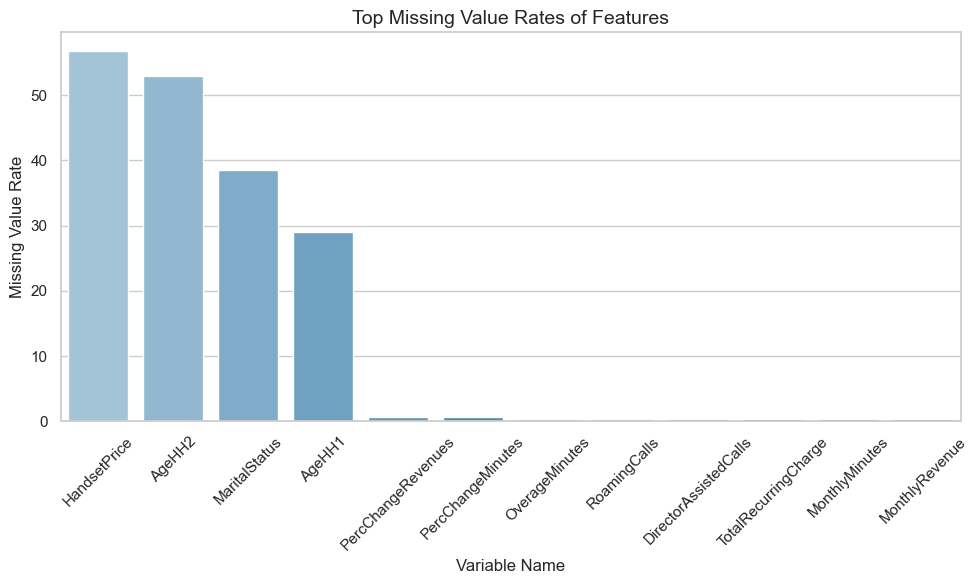

In [372]:
# Creating a DataFrame based on the input table
data = {
    'Variable_Name': [
        'HandsetPrice', 'AgeHH2', 'MaritalStatus', 'AgeHH1', 'PercChangeRevenues', 
        'PercChangeMinutes', 'OverageMinutes', 'RoamingCalls', 'DirectorAssistedCalls', 
        'TotalRecurringCharge', 'MonthlyMinutes', 'MonthlyRevenue'],
    'Missing_Value_Rate': [
        56.775100, 52.884600, 38.591900, 29.043800, 0.718900, 
        0.718900, 0.305600, 0.305600, 0.305600, 0.305600, 0.305600, 0.305600],
    'Missing_Value': [
        28982, 26996, 19700, 14826, 367, 
        367, 156, 156, 156, 156, 156, 156]
}

df_top_missing = pd.DataFrame(data)

# Plotting the top 12 missing values as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=df_top_missing['Variable_Name'], y=df_top_missing["Missing_Value_Rate"], palette="Blues_d")
plt.title('Top Missing Value Rates of Features', fontsize=14)
plt.xlabel('Variable Name', fontsize=12)
plt.ylabel('Missing Value Rate', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot for the appendix
plt.show()

# EXPLORATORY DATA ANALYSIS (EDA)
###  Exploring the attributes that may cause churn

In [373]:
#Creating new dataframes for churned and not churned
df_churned =df_all[df_all['Churn']=='Yes']
df_not_churned= df_all[df_all['Churn']=='No']


# Calculate Number of Churners and Non Churners
churned= df_all[df_all['Churn']=='Yes'].shape[0]
notchurned= df_all[df_all['Churn']=='No'].shape[0]

# Print number of Churners and NonChurners
print("Total Churned customer {} ".format(churned)) 
print("Total not churned customer {} ".format(notchurned)) 

Total Churned customer 14711 
Total not churned customer 36336 


Distribution of Churners and Non Churners on the independent Variables 

Do not Run this code ???

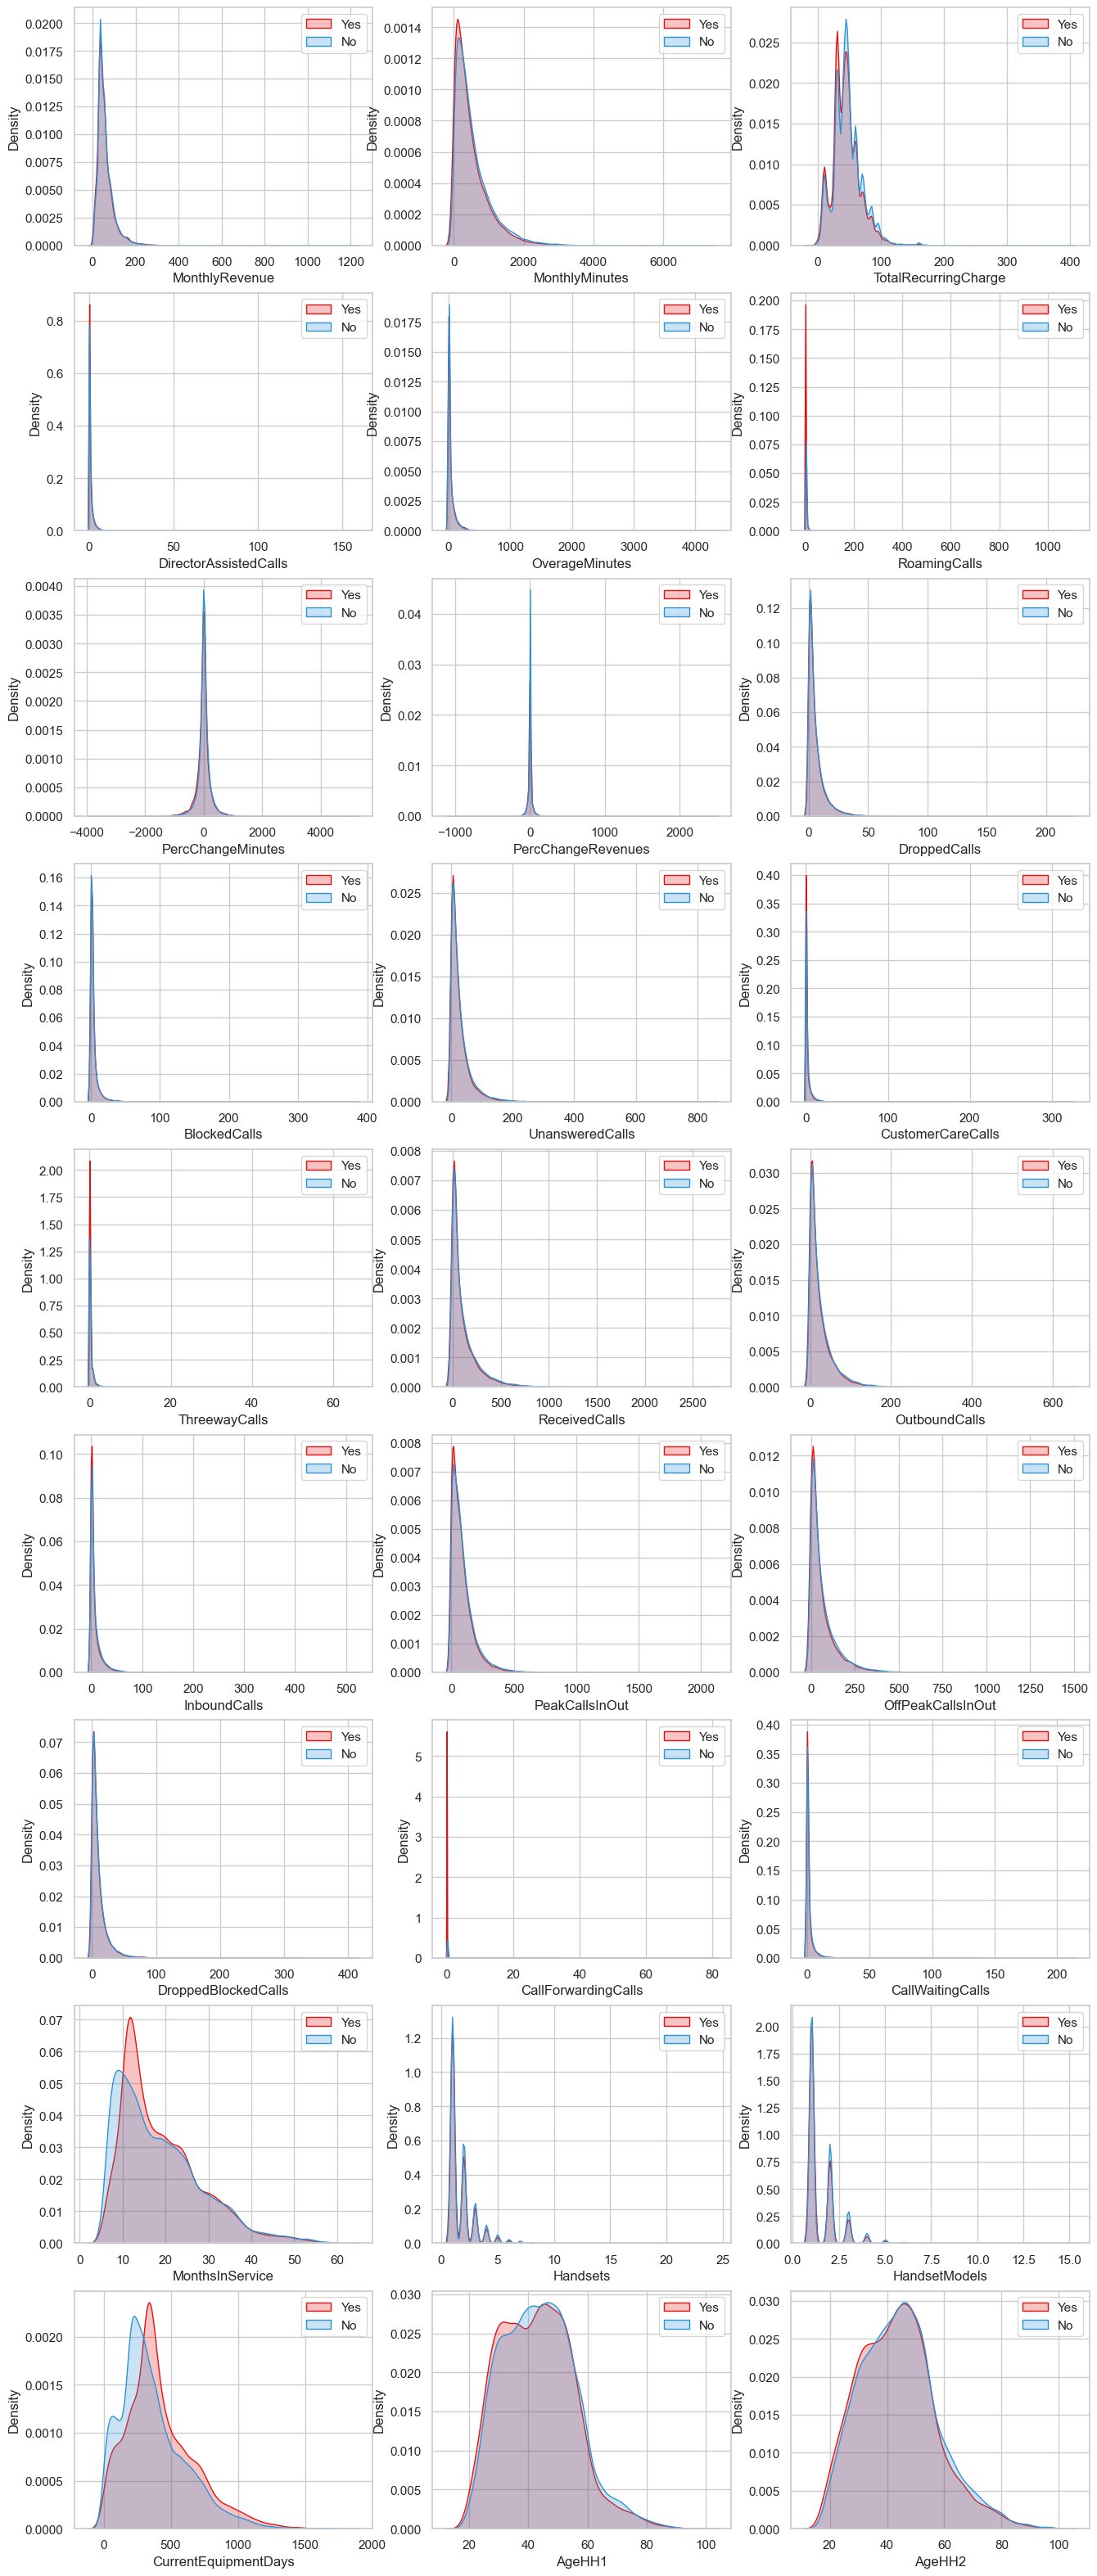

In [374]:
# Lists of Numerical and Categorical collums
num_columns=list(df_info[((df_info["Variable"]=="Continuous-Ratio")|(df_info["Variable"]=="Continuous-Interval"))]["Variable_Name"])
new_list=["CallForwardingCalls","RetentionCalls","RetentionOffersAccepted","ReferralsMadeBySubscriber","AdjustmentsToCreditRating"]

# Extra lists for special cases of Variables 
two_unique_list=list(df_info[((df_info["Variable"]=="Nominal")|(df_info["Variable"]=="Ordinal"))&(df_info["Nunique_Values"]==2)]["Variable_Name"])
two_unique_list.remove("Churn")
order_cat_list=["CreditRating","PrizmCode","Occupation","MaritalStatus"]

# Plotting 
fig,ax=plt.subplots(9,3,figsize=(16,40))
count=0
for i in range(9):
    for j in range(3):
        sns.kdeplot(df_all[df_all["Churn"]=="Yes"][num_columns[count]],ax=ax[i][j],color="#e61010",shade=True)
        sns.kdeplot(df_all[df_all["Churn"]=="No"][num_columns[count]],ax=ax[i][j],color="#2c92d5",shade=True)
        ax[i][j].legend(loc="upper right",labels=["Yes","No"])
        count+=1

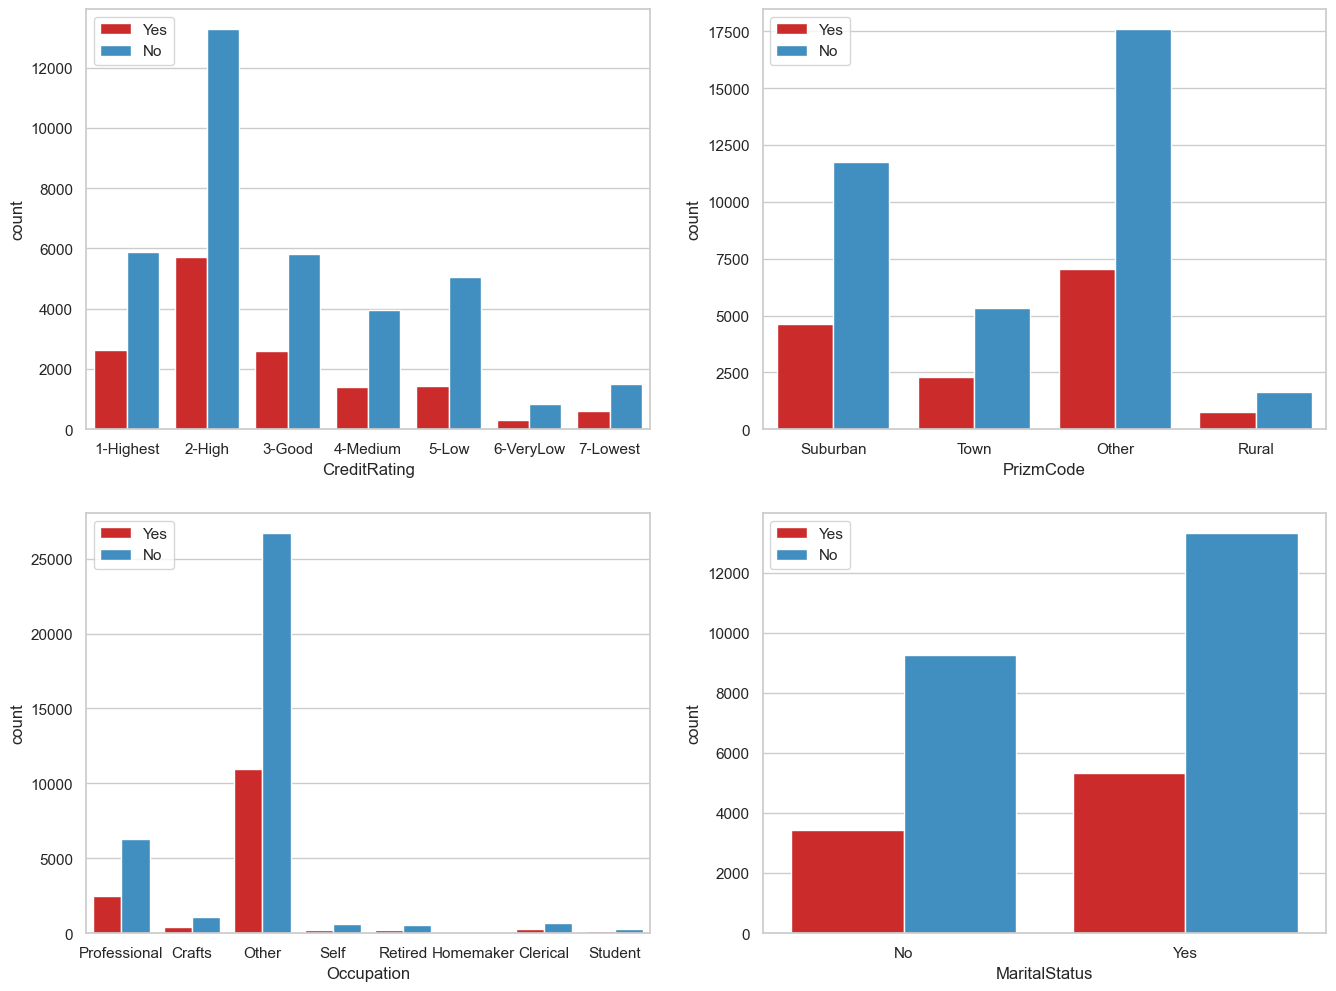

In [375]:
# More Plots 
credit_rating_order=["1-Highest","2-High","3-Good","4-Medium","5-Low","6-VeryLow","7-Lowest"]
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
count = 0
for i in range(2):
    for j in range(2):
        if count == 0:
            sns.countplot(x=order_cat_list[count], data=df_all, ax=ax[i][j], order=credit_rating_order, palette=["#e61010","#2c92d5"], hue="Churn")
        else:  
            sns.countplot(x=order_cat_list[count], data=df_all, ax=ax[i][j], palette=["#e61010","#2c92d5"], hue="Churn")
        ax[i][j].legend(loc="upper left")
        count += 1

In [376]:
# We need a dataframe that keeps the data of the customer doing the retentioncall.
# Lets see how many of the customers who received a retention call then churned.

df_receivedretentioncall = df_all[df_all['MadeCallToRetentionTeam']=='Yes']

print("Number of customer who churn after retentioncall {}".format(df_receivedretentioncall[df_receivedretentioncall['Churn']=='Yes'].shape[0]))
print("Number of customer who don't churn after retentioncall {}".format(df_receivedretentioncall[df_receivedretentioncall['Churn']=='No'].shape[0]))

Number of customer who churn after retentioncall 786
Number of customer who don't churn after retentioncall 959


 Need to modify the code because for some customers we have multiple calls and not just 1 so we need to take that into account for the success of retention calls.
 E.g., Example can be one customer had received 3 calls and accepted 2 offers then churned or another customer has accepted 3/3 offers.

In [378]:
# Modified code 
# Calculate the total number of retention calls made
total_calls = df_receivedretentioncall['RetentionCalls'].sum()

# Calculate the total number of retention offers accepted
total_accepted = df_receivedretentioncall['RetentionOffersAccepted'].sum()

# Calculate the retention effectiveness
retention_effectiveness = total_accepted / total_calls

# Print the retention effectiveness
print("Retention calls effectiveness is {}".format(retention_effectiveness))

Retention calls effectiveness is 0.48421453023963484


In [379]:
df_receivedretentioncall

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,dataset,CLV,unknown_count
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,30,Yes,1-Highest,Suburban,Professional,No,train,11502.857143,0
15,3000082,Yes,172.44,1978.0,100.0,0.00,362.0,0.0,-1007.0,-72.5,...,0,150,Yes,1-Highest,Other,Professional,NaN,train,78583.371429,1
54,3000362,No,35.30,148.0,45.0,0.00,0.0,0.0,-86.0,-0.3,...,3,40,Yes,4-Medium,Suburban,Other,NaN,train,13867.857143,1
104,3000730,Yes,117.12,490.0,70.0,0.00,140.0,0.0,506.0,133.8,...,0,30,Yes,6-VeryLow,Suburban,Other,NaN,train,46931.657143,1
141,3001082,Yes,63.30,415.0,45.0,1.24,88.0,1.5,156.0,38.0,...,0,30,Yes,3-Good,Suburban,Other,Yes,train,24867.857143,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70938,3397742,NaN,53.23,79.0,21.0,0.99,43.0,0.8,37.0,-6.5,...,0,10,Yes,1-Highest,Suburban,Other,No,holdout,12965.307143,1
70963,3398310,NaN,51.02,431.0,35.0,2.72,28.0,0.0,-275.0,-8.8,...,0,10,Yes,7-Lowest,Suburban,Other,NaN,holdout,14030.500000,3
70970,3398418,NaN,51.92,287.0,50.0,0.00,0.0,1.9,-23.0,2.3,...,0,NaN,Yes,3-Good,Other,Other,No,holdout,11830.342857,3
71000,3398942,NaN,58.72,424.0,50.0,0.00,8.0,0.0,-44.0,-2.5,...,0,130,Yes,5-Low,Suburban,Crafts,No,holdout,15225.257143,2


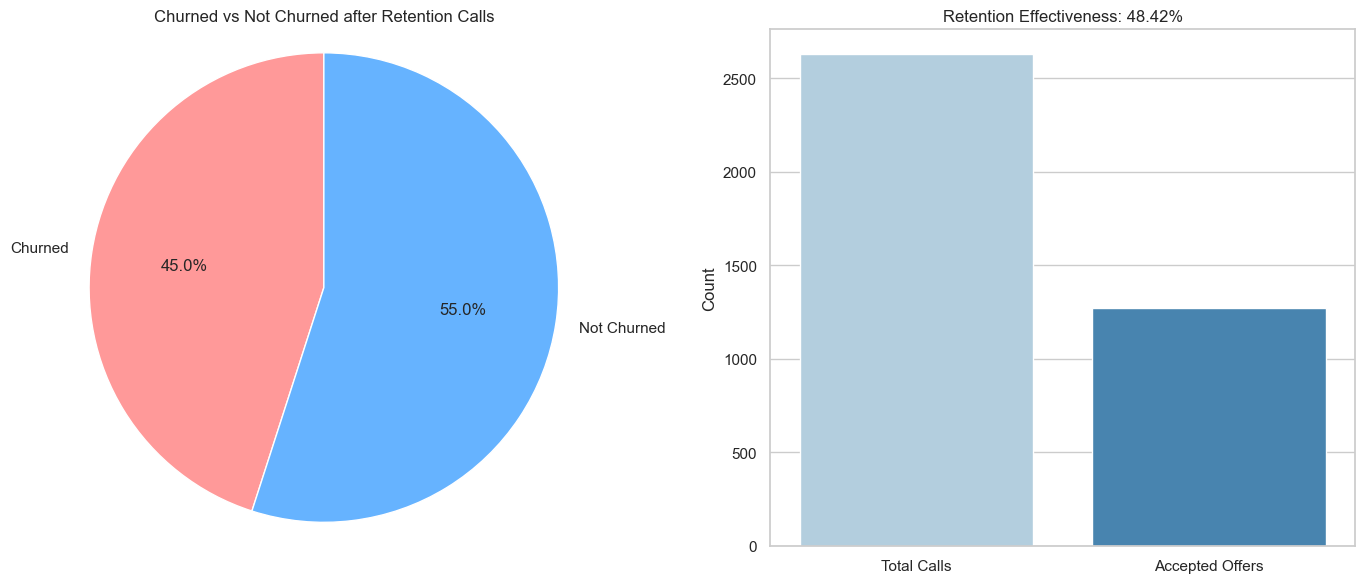

In [383]:
# First, calculate the number of customers who churned and didn't churn
churned_count = df_receivedretentioncall[df_receivedretentioncall['Churn']=='Yes'].shape[0]
not_churned_count = df_receivedretentioncall[df_receivedretentioncall['Churn']=='No'].shape[0]

# Calculate the total number of retention calls made and retention offers accepted
total_calls = df_receivedretentioncall['RetentionCalls'].sum()
total_accepted = df_receivedretentioncall['RetentionOffersAccepted'].sum()

# Calculate the retention effectiveness
retention_effectiveness = total_accepted / total_calls

# Prepare the data for plotting
labels = ['Churned', 'Not Churned']
sizes = [churned_count, not_churned_count]
colors = ['#ff9999','#66b3ff']

# Create a pie chart for the churned vs not churned
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0].axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
axes[0].set_title('Churned vs Not Churned after Retention Calls')

# Create a bar plot for the retention effectiveness
sns.barplot(x=['Total Calls', 'Accepted Offers'], y=[total_calls, total_accepted], ax=axes[1], palette='Blues')
axes[1].set_title(f'Retention Effectiveness: {retention_effectiveness:.2%}')
axes[1].set_ylabel('Count')

# Display the plots
plt.tight_layout()
plt.show()

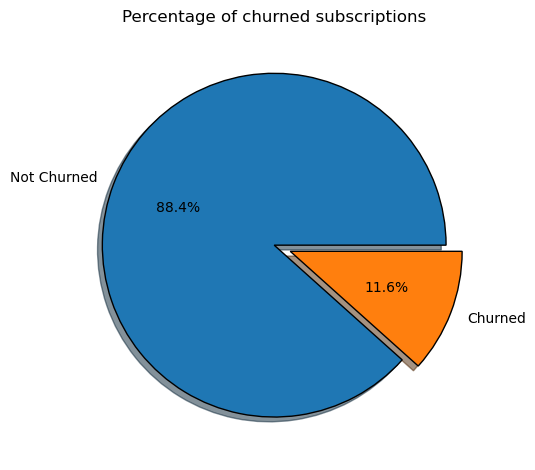

In [ ]:
df_all['ChurnSubs']=df_all['UniqueSubs']-df_all['ActiveSubs']
slices=[df_all['ActiveSubs'].sum(),df_all['ChurnSubs'].sum()]
labels=['Not Churned','Churned']
explode=[0,0.1]

plt.pie(slices,labels=labels,explode=explode,wedgeprops={'edgecolor':'black'},shadow=True,autopct='%1.1f%%')
plt.title("Percentage of churned subscriptions")

plt.tight_layout()
plt.show()

In [ ]:
print ("Active Subs number {}".format(df_all['ActiveSubs'].sum()))
print ("Churned Subs number {}".format(df_all['ChurnSubs'].sum()))

Active Subs number 96031
Churned Subs number 12639


### REtention Effectivness Anlaysis

In [385]:
# Creating a new dataframe for the customers who received calls
df_retentions = df_all[df_all['MadeCallToRetentionTeam'] =='Yes']

### Plot the distribution of customers who received retention calls (df_retentions):

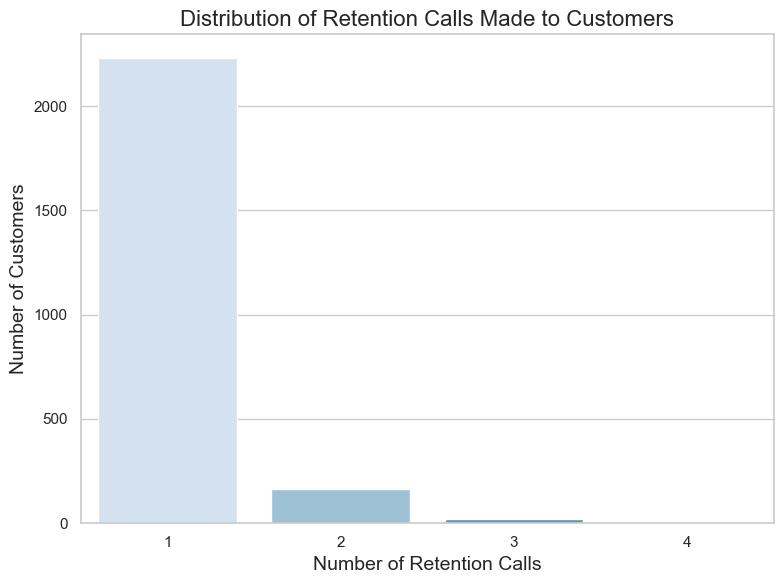

In [386]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of customers who received retention calls
plt.figure(figsize=(8, 6))
sns.countplot(x='RetentionCalls', data=df_retentions, palette='Blues')

# Add title and labels
plt.title('Distribution of Retention Calls Made to Customers', fontsize=16)
plt.xlabel('Number of Retention Calls', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

### Step 2: Retention Offer Acceptance Insights
Analyze who accepts retention offers more often:

In [ ]:
# Plot the number of retention calls accepted
plt.figure(figsize=(8, 6))
sns.countplot(x='RetentionOffersAccepted', data=df_retentions, palette='Set2')

# Add title and labels
plt.title('Retention Offers Accepted by Customers', fontsize=16)
plt.xlabel('Accepted Retention Offer (Yes/No)', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

### Explore the relationship between CLV and RetentionOffersAccepted:

In [ ]:
# Boxplot to compare CLV for customers who accepted and didn't accept offers
plt.figure(figsize=(8, 6))
sns.boxplot(x='RetentionOffersAccepted', y='CLV', data=df_retentions, palette='Set1')

# Add title and labels
plt.title('Retention Offer Acceptance by Customer Lifetime Value', fontsize=16)
plt.xlabel('Retention Offer Accepted (Yes/No)', fontsize=14)
plt.ylabel('Customer Lifetime Value (CLV)', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

### not clear insights better to plot average CLV of customers accepted and customer who did not accept


In [387]:
# Calculate average CLV for customers who accepted at least 1 offer
accepted_offer_clv = df_all[df_all['RetentionOffersAccepted'] > 0]['CLV'].mean()

# Calculate average CLV for customers who did not accept any offers
no_offer_clv = df_all[df_all['RetentionOffersAccepted'] == 0]['CLV'].mean()

# Print the results
print(f"Average CLV for customers who accepted offers: €{accepted_offer_clv:,.2f}")
print(f"Average CLV for customers who did not accept offers: €{no_offer_clv:,.2f}")

Average CLV for customers who accepted offers: €11,514.56
Average CLV for customers who did not accept offers: €8,603.50


### First, drop the 216 columns from the holdout dataframe WHERE most values are missing

In [ ]:
#remove rows where CLV is missing
df_all = df_all.dropna(subset=['CLV'])


In [ ]:
#Split the data back into separate DataFrames
df_holdout = df[df['dataset'] == 'holdout'].drop('dataset', axis=1)
df_all = df[df['dataset'] == 'train'].drop('dataset', axis=1)

# TRAIN TEST VALIDATION SPLIT
The dataset splits into three subsets: 

        training set size 80% of the df_all
        test set size 20% of the df_all dataset
        validation set size 100% of the holdout dataset

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split df_all into features and target variable
X = df_all.drop(["Churn"], axis=1)  # Features
y = df_all["Churn"]  # Target variable

# Split the dataset into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The holdout dataset remains as is for validation purposes
X_val = df_holdout.drop(["Churn"], axis=1)  # Features for holdout
y_val = df_holdout["Churn"]  # Target variable for holdout (if available)

In [21]:
# Subsets are added
df_train=pd.concat([X_train,y_train],axis=1)
df_test=pd.concat([X_test,y_test],axis=1)
df_val=pd.concat([X_val,y_val],axis=1)

# OUTLIER HANDLING

In [22]:
#Create a copy of data to work on
df_outlier=df_all.copy()

sparse_columns=[]
for col in num_columns:
    if (df_train[col].quantile(0.01)==df_train[col].quantile(0.25)==df_train[col].mode()[0]):
        sparse_columns.append(col)

In [392]:
iqr_df = pd.DataFrame(index = num_columns, columns = ["Q1","Q3","IQR","Lower-Bound","Lower-Outlier-Value","Upper-Bound","Upper-Outlier-Value", "#-of-Outliers"])
df_train_outlier_cleaned = df_train.copy()

for col in num_columns:

  if col in sparse_columns :
    q1 = df_train_outlier_cleaned.describe().loc['25%',col]
    q3 = df_train_outlier_cleaned.describe().loc['75%',col]
    iqr = q3 - q1
    upper_bound = q3 + 1.5*iqr
    lower_bound = q1 - 1.5*iqr
    number_of_outlier = df_train_outlier_cleaned.loc[(df_train_outlier_cleaned.loc[:,col]<lower_bound) | (df_train_outlier_cleaned.loc[:,col]>upper_bound)].shape[0]

    print("Sparse:",col)

    if lower_bound < 0:
      lower_outlier_value = lower_bound * 1.25
    else:
      lower_outlier_value = lower_bound * 0.75

    iqr_df.loc[col,:] = [q1,q3,iqr,lower_bound,lower_outlier_value,upper_bound,upper_bound*1.25,number_of_outlier]

    df_train_outlier_cleaned.loc[(df_train_outlier_cleaned.loc[:,col]<lower_bound),col] =  lower_outlier_value
    df_train_outlier_cleaned.loc[(df_train_outlier_cleaned.loc[:,col]>upper_bound),col] =  upper_bound*1.25

  else: # sparse situation
    most_frequent_item = df_train_outlier_cleaned[col].mode()[0]
    nonsparse_data = pd.DataFrame(df_train_outlier_cleaned[df_train_outlier_cleaned[col] != most_frequent_item][col])
    
    print("Non-Sparse:",col)
    
    q1 = nonsparse_data.describe().loc['25%',col]
    # print("q1 =",q1, col)
    q3 = nonsparse_data.describe().loc['75%',col]
    # print("q3 =",q3, col)
    iqr = q3 - q1
    # print("iqr =",iqr, col)
    upper_bound = q3 + 1.5*iqr
    lower_bound = q1 - 1.5*iqr
    number_of_outlier = nonsparse_data.loc[(nonsparse_data.loc[:,col]<lower_bound) | (nonsparse_data.loc[:,col]>upper_bound)].shape[0]

    if lower_bound < 0:
      lower_outlier_value = lower_bound * 1.25
      df_train_outlier_cleaned.loc[(df_train_outlier_cleaned.loc[:,col]<lower_bound) & (df_train_outlier_cleaned.loc[:,col] != 0),col] =  lower_outlier_value # lower_bound - 0.25*iqr 
      # print("lower_bound negative")
    else:
      lower_outlier_value = lower_bound * 0.75
      df_train_outlier_cleaned.loc[(df_train_outlier_cleaned.loc[:,col]<lower_bound) & (df_train_outlier_cleaned.loc[:,col] != 0),col] =  lower_outlier_value # lower_bound - 0.25*iqr 
      # print("lower_bound positive")

    iqr_df.loc[col,:] = [q1,q3,iqr,lower_bound,lower_outlier_value,upper_bound,upper_bound*1.25,number_of_outlier]

    df_train_outlier_cleaned.loc[(df_train_outlier_cleaned.loc[:,col]>upper_bound),col] =  upper_bound*1.25 # upper_bound + 0.25*iqr 
    
iqr_df

Non-Sparse: MonthlyRevenue
Non-Sparse: MonthlyMinutes
Non-Sparse: TotalRecurringCharge
Sparse: DirectorAssistedCalls
Sparse: OverageMinutes
Sparse: RoamingCalls
Non-Sparse: PercChangeMinutes
Non-Sparse: PercChangeRevenues
Non-Sparse: DroppedCalls
Sparse: BlockedCalls
Non-Sparse: UnansweredCalls
Sparse: CustomerCareCalls
Sparse: ThreewayCalls
Non-Sparse: ReceivedCalls
Non-Sparse: OutboundCalls
Sparse: InboundCalls
Non-Sparse: PeakCallsInOut
Non-Sparse: OffPeakCallsInOut
Non-Sparse: DroppedBlockedCalls
Sparse: CallForwardingCalls
Sparse: CallWaitingCalls
Non-Sparse: MonthsInService
Sparse: Handsets
Sparse: HandsetModels
Non-Sparse: CurrentEquipmentDays
Non-Sparse: AgeHH1
Non-Sparse: AgeHH2


,Q1,Q3,IQR,Lower-Bound,Lower-Outlier-Value,Upper-Bound,Upper-Outlier-Value,#-of-Outliers
MonthlyRevenue,34.48,72.2175,37.7375,-22.12625,-27.657813,128.82375,161.029688,2342
MonthlyMinutes,166.0,732.0,566.0,-683.0,-853.75,1581.0,1976.25,2018
TotalRecurringCharge,40.0,60.0,20.0,10.0,7.5,90.0,112.5,2164
DirectorAssistedCalls,0.0,0.99,0.99,-1.485,-1.85625,2.475,3.09375,4390
OverageMinutes,0.0,41.0,41.0,-61.5,-76.875,102.5,128.125,4754
RoamingCalls,0.0,0.3,0.3,-0.45,-0.5625,0.75,0.9375,7058
PercChangeMinutes,-86.0,69.0,155.0,-318.5,-398.125,301.5,376.875,5168
PercChangeRevenues,-9.1,3.1,12.2,-27.4,-34.25,21.4,26.75,8330
DroppedCalls,1.7,8.7,7.0,-8.8,-11.0,19.2,24.0,2685
BlockedCalls,0.0,3.7,3.7,-5.55,-6.9375,9.25,11.5625,4429


In [313]:
number_of_outlier_test = pd.DataFrame(index = num_columns, columns = ["#-of-Outliers"])
df_test_outlier_cleaned = df_test.copy()

for col in num_columns:

  if col in sparse_columns:
    number_of_outlier_test.loc[col,"#-of-Outliers"] = df_test_outlier_cleaned.loc[(df_test_outlier_cleaned.loc[:,col]<iqr_df.loc[col,"Lower-Bound"]) | (df_test_outlier_cleaned.loc[:,col]>iqr_df.loc[col,"Upper-Bound"])].shape[0]

    print("Sparce:",col)

    df_test_outlier_cleaned.loc[(df_test_outlier_cleaned.loc[:,col]<iqr_df.loc[col,"Lower-Bound"]),col] =  iqr_df.loc[col,"Lower-Outlier-Value"]
    df_test_outlier_cleaned.loc[(df_test_outlier_cleaned.loc[:,col]>iqr_df.loc[col,"Upper-Bound"]),col] =  iqr_df.loc[col,"Upper-Outlier-Value"]

  else: # sparse 
    most_frequent_item = df_test_outlier_cleaned[col].mode()[0]
    nonsparse_data = pd.DataFrame(df_test_outlier_cleaned[df_test_outlier_cleaned[col] != most_frequent_item][col])

    print("Non-Sparce:",col)
    
    number_of_outlier_test.loc[col,"#-of-Outliers"] = nonsparse_data.loc[(nonsparse_data.loc[:,col]<iqr_df.loc[col,"Lower-Bound"]) | (nonsparse_data.loc[:,col]>iqr_df.loc[col,"Upper-Bound"])].shape[0]

    df_test_outlier_cleaned.loc[(df_test_outlier_cleaned.loc[:,col]<iqr_df.loc[col,"Lower-Bound"]) & (df_test_outlier_cleaned.loc[:,col] != 0),col] =  iqr_df.loc[col,"Lower-Outlier-Value"]
    df_test_outlier_cleaned.loc[(df_test_outlier_cleaned.loc[:,col]>iqr_df.loc[col,"Upper-Bound"]),col] =  iqr_df.loc[col,"Upper-Outlier-Value"]
    
number_of_outlier_test

Non-Sparce: PercChangeRevenues
Non-Sparce: OffPeakCallsInOut
Non-Sparce: unknown_count


KeyError: 'unknown_count'

In [25]:
number_of_outlier_val = pd.DataFrame(index = num_columns, columns = ["#-of-Outliers"])
df_val_outlier_cleaned = df_val.copy()

for col in num_columns:

  if col in sparse_columns:
    number_of_outlier_val.loc[col,"#-of-Outliers"] = df_val_outlier_cleaned.loc[(df_val_outlier_cleaned.loc[:,col]<iqr_df.loc[col,"Lower-Bound"]) | (df_val_outlier_cleaned.loc[:,col]>iqr_df.loc[col,"Upper-Bound"])].shape[0]

    print("Sparce",col)

    df_val_outlier_cleaned.loc[(df_val_outlier_cleaned.loc[:,col]<iqr_df.loc[col,"Lower-Bound"]),col] =  iqr_df.loc[col,"Lower-Outlier-Value"]
    df_val_outlier_cleaned.loc[(df_val_outlier_cleaned.loc[:,col]>iqr_df.loc[col,"Upper-Bound"]),col] =  iqr_df.loc[col,"Upper-Outlier-Value"]

  else: # sparse 
    most_frequent_item = df_val_outlier_cleaned[col].mode()[0]
    nonsparse_data = pd.DataFrame(df_val_outlier_cleaned[df_val_outlier_cleaned[col] != most_frequent_item][col])

    print("Non-Sparse:",col)
    
    number_of_outlier_val.loc[col,"#-of-Outliers"] = nonsparse_data.loc[(nonsparse_data.loc[:,col]<iqr_df.loc[col,"Lower-Bound"]) | (nonsparse_data.loc[:,col]>iqr_df.loc[col,"Upper-Bound"])].shape[0]

    df_val_outlier_cleaned.loc[(df_val_outlier_cleaned.loc[:,col]<iqr_df.loc[col,"Lower-Bound"]) & (df_val_outlier_cleaned.loc[:,col] != 0),col] =  iqr_df.loc[col,"Lower-Outlier-Value"]
    df_val_outlier_cleaned.loc[(df_val_outlier_cleaned.loc[:,col]>iqr_df.loc[col,"Upper-Bound"]),col] =  iqr_df.loc[col,"Upper-Outlier-Value"]
    
number_of_outlier_val

Non-Sparse: MonthlyRevenue
Non-Sparse: MonthlyMinutes
Non-Sparse: TotalRecurringCharge
Sparce DirectorAssistedCalls
Sparce OverageMinutes
Sparce RoamingCalls
Non-Sparse: PercChangeMinutes
Non-Sparse: PercChangeRevenues
Non-Sparse: DroppedCalls
Sparce BlockedCalls
Non-Sparse: UnansweredCalls
Sparce CustomerCareCalls
Sparce ThreewayCalls
Non-Sparse: ReceivedCalls
Non-Sparse: OutboundCalls
Sparce InboundCalls
Non-Sparse: PeakCallsInOut
Non-Sparse: OffPeakCallsInOut
Non-Sparse: DroppedBlockedCalls
Sparce CallForwardingCalls
Sparce CallWaitingCalls
Non-Sparse: MonthsInService
Sparce Handsets
Sparce HandsetModels
Non-Sparse: CurrentEquipmentDays
Non-Sparse: AgeHH1
Non-Sparse: AgeHH2


,#-of-Outliers
MonthlyRevenue,1157
MonthlyMinutes,1015
TotalRecurringCharge,995
DirectorAssistedCalls,2109
OverageMinutes,2317
RoamingCalls,3486
PercChangeMinutes,2487
PercChangeRevenues,3979
DroppedCalls,1322
BlockedCalls,2184


# MISSING VALUE HANDLING

In [26]:
df_missing=df_outlier.copy()

df_train_missing=df_train_outlier_cleaned.copy()
df_test_missing=df_test_outlier_cleaned.copy()
df_val_missing=df_val_outlier_cleaned.copy()

In [27]:
    df_info[(df_info["Missing_Value_Rate"]>0) & (df_info["Missing_Value_Rate"]<5)]

,Variable_Name,Type,Total_Entry,Missing_Value,Missing_Value_Rate,Unique_Values,Nunique_Values,Mean,Median,Min,Max,Variable
2,MonthlyRevenue,float64,70831,216,0.3040,"[24.0, 16.99, 38.0, 82.28, 17.14, 38.05, 31.66...",14266,58.85,48.53,-6.170000,1223.380000,Continuous-Ratio
3,MonthlyMinutes,float64,70831,216,0.3040,"[219.0, 10.0, 8.0, 1312.0, 0.0, 682.0, 26.0, 9...",2898,525.73,366.00,0.000000,7668.000000,Continuous-Ratio
4,TotalRecurringCharge,float64,70831,216,0.3040,"[22.0, 17.0, 38.0, 75.0, 52.0, 30.0, 66.0, 35....",223,46.86,45.00,-11.000000,400.000000,Continuous-Ratio
5,DirectorAssistedCalls,float64,70831,216,0.3040,"[0.25, 0.0, 1.24, 2.48, 2.23, 0.5, 0.99, 2.97,...",157,0.89,0.25,0.000000,159.390000,Continuous-Ratio
6,OverageMinutes,float64,70831,216,0.3040,"[0.0, 250.0, 6.0, 2.0, 362.0, 10.0, 14.0, 97.0...",823,40.09,2.00,0.000000,4321.000000,Continuous-Ratio
7,RoamingCalls,float64,70831,216,0.3040,"[0.0, 35.5, 1.3, 2.6, 1.9, 1.8, 0.1, 6.7, 2.1,...",609,1.22,0.00,0.000000,1112.400000,Continuous-Ratio
8,PercChangeMinutes,float64,70545,502,0.7066,"[-157.0, -4.0, -2.0, 157.0, 0.0, 148.0, 60.0, ...",2442,-10.85,-5.00,-3875.000000,5192.000000,Continuous-Ratio
9,PercChangeRevenues,float64,70545,502,0.7066,"[-19.0, 0.0, 8.1, -0.2, -3.1, 4.0, 6.8, -0.3, ...",3208,-1.20,-0.30,-1107.700000,2483.500000,Continuous-Ratio
26,ServiceArea,object,71019,28,0.0394,"[SEAPOR503, PITHOM412, MILMIL414, OKCTUL918, O...",773,NaN,NaN,NaN,NaN,Nominal
27,Handsets,float64,71046,1,0.0014,"[2.0, 1.0, 9.0, 4.0, 3.0, 10.0, 5.0, 8.0, 18.0...",24,1.81,1.00,1.000000,28.000000,Continuous-Interval


In [28]:
# better handle missing values for AgeHH1, AgeHH2 and HandsetPrice features with KNNImputer method 
# as its better when we got correlation between variables and AgeHH1 is probably correlated with AgeHH2

imputer=KNNImputer()

df_train_missing[["AgeHH1"]]=imputer.fit_transform(df_train_missing[["AgeHH1"]])
df_test_missing[["AgeHH1"]]=imputer.transform(df_test_missing[["AgeHH1"]])
df_val_missing[["AgeHH1"]]=imputer.transform(df_val_missing[["AgeHH1"]])

df_train_missing[["AgeHH2"]]=imputer.fit_transform(df_train_missing[["AgeHH2"]])
df_test_missing[["AgeHH2"]]=imputer.transform(df_test_missing[["AgeHH2"]])
df_val_missing[["AgeHH2"]]=imputer.transform(df_val_missing[["AgeHH2"]])

df_train_missing[["HandsetPrice"]]=imputer.fit_transform(df_train_missing[["HandsetPrice"]])
df_test_missing[["HandsetPrice"]]=imputer.transform(df_test_missing[["HandsetPrice"]])
df_val_missing[["HandsetPrice"]]=imputer.transform(df_val_missing[["HandsetPrice"]])

df_train_missing[["HandsetPrice"]]=df_train_missing[["HandsetPrice"]].astype("float64")
df_test_missing[["HandsetPrice"]]=df_test_missing[["HandsetPrice"]].astype("float64")
df_val_missing[["HandsetPrice"]]=df_val_missing[["HandsetPrice"]].astype("float64")

In [29]:
# new category <unknown> for Marritan status to keep the information and not remove all the missing columns
df_train_missing['MaritalStatus'].replace(np.nan,"Unknown", inplace = True)
df_test_missing['MaritalStatus'].replace(np.nan,"Unknown", inplace = True)
df_val_missing['MaritalStatus'].replace(np.nan,"Unknown", inplace = True)

# FEATURE GENERATION

In [30]:
def feature_gen(df):
    # 1. Calculate new feature and merge
    data = df.groupby(["MonthlyMinutes"])[["PercChangeMinutes"]].mean()
    data.columns = ["monthMinPerc"]
    df = pd.merge(df, data, on="MonthlyMinutes", how="left")
    
    # 2. Calculate new feature and merge
    data = df.groupby(["PercChangeMinutes"])[["MonthlyMinutes"]].mean()
    data.columns = ["percMonthMin"]
    df = pd.merge(df, data, on="PercChangeMinutes", how="left")

    # 3. Repeat the process for the rest of the feature generation steps
    data = df.groupby(["MonthlyRevenue"])[["MonthlyMinutes"]].mean()
    data.columns = ["monthRevMin"]
    df = pd.merge(df, data, on="MonthlyRevenue", how="left")
    
    data = df.groupby(["PercChangeRevenues"])[["PercChangeMinutes"]].mean()
    data.columns = ["percChangeRevMin"]
    df = pd.merge(df, data, on="PercChangeRevenues", how="left")

    data = df.groupby(["DroppedCalls"])[["BlockedCalls"]].mean()
    data.columns = ["DropBlock"]
    df = pd.merge(df, data, on="DroppedCalls", how="left")

    data = df.groupby(["BlockedCalls"])[["DroppedCalls"]].mean()
    data.columns = ["BlockDrop"]
    df = pd.merge(df, data, on="BlockedCalls", how="left")

    # Add new features directly without needing to merge
    df["RetentionOfferNotAccepted"] = df["RetentionCalls"] - df["RetentionOffersAccepted"]
    df["TotalHH"] = df["AgeHH1"] + df["AgeHH2"]
 
    # Drop both '_x' and '_y' columns
    cols_to_drop = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]
    df = df.drop(columns=cols_to_drop)

    return df

# Apply feature generation to all datasets
df_train_missing = feature_gen(df_train_missing)
df_test_missing = feature_gen(df_test_missing)
df_val_missing = feature_gen(df_val_missing)


# ENCODING

In [31]:
df_encode=df_missing.copy()

df_train_encode=df_train_missing.copy()
df_test_encode=df_test_missing.copy()
df_val_encode=df_val_missing.copy()

### Handsetmodel & Handsets Categorizing
Before Encoding step, we categorize two value of Handsetprice feature.

In [32]:
for i in df_train_encode["HandsetModels"].unique():
    if i==1.0:
        df_train_encode.loc[df_train_encode["HandsetModels"]==i,"HandsetModels"]="Model1"
        df_test_encode.loc[df_test_encode["HandsetModels"]==i,"HandsetModels"]="Model1"
        df_val_encode.loc[df_val_encode["HandsetModels"]==i,"HandsetModels"]="Model1"
    else:
        df_train_encode.loc[df_train_encode["HandsetModels"]==i,"HandsetModels"]="Model2"
        df_test_encode.loc[df_test_encode["HandsetModels"]==i,"HandsetModels"]="Model2"
        df_val_encode.loc[df_val_encode["HandsetModels"]==i,"HandsetModels"]="Model2"

In [33]:
for i in df_train_encode["Handsets"].unique():
    if i!=1.0:
        df_train_encode.loc[df_train_encode["Handsets"]==i,"Handsets"]="Handsets1"
        df_test_encode.loc[df_test_encode["Handsets"]==i,"Handsets"]="Handsets1"
        df_val_encode.loc[df_val_encode["Handsets"]==i,"Handsets"]="Handsets1"
    else:
        df_train_encode.loc[df_train_encode["Handsets"]==i,"Handsets"]="Handsets2"
        df_test_encode.loc[df_test_encode["Handsets"]==i,"Handsets"]="Handsets2"
        df_val_encode.loc[df_val_encode["Handsets"]==i,"Handsets"]="Handsets2"

## Label Encoder

In [34]:
# Get the number of NaNs in each dataframe
num_nans_train = df_train_encode.isna().sum().sum()
num_nans_test = df_test_encode.isna().sum().sum()
num_nans_val = df_val_encode.isna().sum().sum()

# Print the results
print(f"Number of NaNs in df_train_encode: {num_nans_train}")
print(f"Number of NaNs in df_test_encode: {num_nans_test}")
print(f"Number of NaNs in df_val_encode: {num_nans_val}")


Number of NaNs in df_train_encode: 2315
Number of NaNs in df_test_encode: 584
Number of NaNs in df_val_encode: 21084


In [35]:
df_train_encode = df_train_encode.dropna()
df_test_encode = df_test_encode.dropna()
# For df_val_encode, drop NAs except from the 'Churn' column
df_val_encode = df_val_encode.loc[:, df_val_encode.columns != 'Churn'].dropna().join(df_val_encode['Churn'])

### For Feature has equal to two unique values, use LabelEncoder method.


In [36]:

# Add the dataset identifier as it previusly existed and we get an error if its not in
df_train_encode['dataset'] = 'train'
df_test_encode['dataset'] = 'train'
df_val_encode['dataset'] = 'train'

# Create a list of features with exactly two unique values, excluding 'Churn' and 'MaritalStatus'
liste = list(df_info[(df_info["Type"] == "object") & (df_info["Nunique_Values"] == 2)]["Variable_Name"])
liste.remove("MaritalStatus")

# Check if 'Churn' is in the list and remove it if it exists
if 'Churn' in liste:
    liste.remove('Churn')

label = LabelEncoder()
for i in liste:
    df_train_encode[i] = label.fit_transform(df_train_encode[i])
    df_test_encode[i] = label.transform(df_test_encode[i])
    #df_val_encode[i] = label.transform(df_val_encode[i])  # Churn will not be included

# Remove the 'dataset' column from all DataFrames as we dont need it anymore
df_train_encode.drop(columns=['dataset'], inplace=True)
df_test_encode.drop(columns=['dataset'], inplace=True)
df_val_encode.drop(columns=['dataset'], inplace=True)

In [37]:
print(df_train_encode.shape)
print(df_test_encode.shape)
print(df_val_encode.shape)

(40522, 69)
(10133, 69)
(19861, 69)


## Ordinal Encoder for CreditRating

In [38]:
# We label CreditRating as "1-Highest" equal to 7 and "7-Lowest" equal to 1.

df_train_encode["CreditRating"].replace('1-Highest',7,inplace=True)
df_train_encode["CreditRating"].replace('2-High',6,inplace=True)
df_train_encode["CreditRating"].replace('3-Good',5,inplace=True)
df_train_encode["CreditRating"].replace('4-Medium',4,inplace=True)
df_train_encode["CreditRating"].replace('5-Low',3,inplace=True)
df_train_encode["CreditRating"].replace('6-VeryLow',2,inplace=True)
df_train_encode["CreditRating"].replace('7-Lowest',1,inplace=True)

df_test_encode["CreditRating"].replace('1-Highest',7,inplace=True)
df_test_encode["CreditRating"].replace('2-High',6,inplace=True)
df_test_encode["CreditRating"].replace('3-Good',5,inplace=True)
df_test_encode["CreditRating"].replace('4-Medium',4,inplace=True)
df_test_encode["CreditRating"].replace('5-Low',3,inplace=True)
df_test_encode["CreditRating"].replace('6-VeryLow',2,inplace=True)
df_test_encode["CreditRating"].replace('7-Lowest',1,inplace=True)

df_val_encode["CreditRating"].replace('1-Highest',7,inplace=True)
df_val_encode["CreditRating"].replace('2-High',6,inplace=True)
df_val_encode["CreditRating"].replace('3-Good',5,inplace=True)
df_val_encode["CreditRating"].replace('4-Medium',4,inplace=True)
df_val_encode["CreditRating"].replace('5-Low',3,inplace=True)
df_val_encode["CreditRating"].replace('6-VeryLow',2,inplace=True)
df_val_encode["CreditRating"].replace('7-Lowest',1,inplace=True)


## DROPPING COLUMNS

In [39]:
# Prefer to drop ServiceArea because of 747 unique values and CustomerID because of 51047 unique values.???

df_train_encode.drop("ServiceArea",axis=1,inplace=True)
df_test_encode.drop("ServiceArea",axis=1,inplace=True)
df_val_encode.drop("ServiceArea",axis=1,inplace=True)


df_train_encode.drop(["CustomerID"],axis=1,inplace=True)
df_test_encode.drop(["CustomerID"],axis=1,inplace=True)
df_val_encode.drop(["CustomerID"],axis=1,inplace=True)

In [40]:
df_train_encode

,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,...,ChurnSubs,Churn,monthMinPerc,percMonthMin,monthRevMin,percChangeRevMin,DropBlock,BlockDrop,RetentionOfferNotAccepted,TotalHH
0,34.710000,123.0,33.0,0.00,0.000,0.0000,-28.000,-0.80,1.7,0.0000,...,0,Yes,-4.140000,253.606557,205.000000,-16.945652,2.411548,2.252809,0,64.000000
1,35.600000,852.0,33.0,0.00,27.000,0.0000,-398.125,-34.25,12.7,2.0000,...,0,No,-0.211957,1071.357415,353.785714,-204.840423,3.526221,7.155994,0,87.764634
2,60.090000,96.0,60.0,2.23,0.000,0.9375,-28.000,-4.20,1.7,0.3000,...,0,No,-0.287671,253.606557,358.090909,-59.308424,2.411548,4.323240,0,76.286112
3,50.310000,772.0,60.0,0.00,0.000,0.3000,153.000,1.00,4.7,4.0000,...,0,No,-24.836538,554.794643,393.571429,17.681180,3.034264,7.493548,0,72.286112
4,12.680000,619.0,10.0,1.98,3.000,0.0000,-83.000,0.80,10.3,11.5625,...,0,Yes,-42.366667,463.933962,392.500000,11.570064,3.734549,9.050056,0,78.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40832,10.250000,83.0,10.0,0.25,0.000,0.0000,-24.000,-0.20,4.7,0.0000,...,1,Yes,0.642857,279.732051,260.963636,-6.450789,3.034264,2.252809,0,74.000000
40833,49.990000,362.0,60.0,0.00,0.000,0.0000,-54.000,0.00,24.0,11.5625,...,0,Yes,-2.710227,361.087786,400.735390,-2.761818,5.180251,9.050056,0,90.286112
40834,34.990000,204.0,45.0,0.00,0.000,0.0000,-24.000,0.00,2.0,2.3000,...,0,No,-9.692308,279.732051,272.963691,-2.761818,2.685901,7.029775,0,78.000000
40835,161.029688,1578.0,112.5,0.00,128.125,0.5000,376.875,26.75,24.0,1.0000,...,0,No,42.662500,1056.816503,1460.037895,198.662059,5.180251,6.171853,0,84.286112


### One-Hot Encoder
    Merge the datasets to get consistent dummies across all sets and then split back into 3 subsets

In [41]:
df_encode2=df_encode.copy()

df_train_encode2=df_train_encode.copy()
df_test_encode2=df_test_encode.copy()
df_val_encode2=df_val_encode.copy()

In [42]:
# Step 1: Identify all unique columns in categorical features across all datasets before encoding
combined = pd.concat([df_train_encode2, df_test_encode2, df_val_encode2], axis=0)

# Step 2: One-hot encode combined data to get all potential columns
combined_encoded = pd.get_dummies(combined)

# Get the complete set of columns from the combined encoded DataFrame
all_columns = combined_encoded.columns

# Step 3: Apply get_dummies to each dataset separately and reindex to have the same columns
df_train_encoded = pd.get_dummies(df_train_encode2).reindex(columns=all_columns, fill_value=0)
df_test_encoded = pd.get_dummies(df_test_encode2).reindex(columns=all_columns, fill_value=0)
df_val_encoded = pd.get_dummies(df_val_encode2).reindex(columns=all_columns, fill_value=0)

# Step 4: Verify that all datasets have the same columns and shapes
print(f"Train shape: {df_train_encoded.shape}")
print(f"Test shape: {df_test_encoded.shape}")
print(f"Validation shape: {df_val_encoded.shape}")

# Now we can use the consistent encoded data for further analysis or modeling

Train shape: (40522, 130)
Test shape: (10133, 130)
Validation shape: (19861, 130)


In [43]:
print(df_train_encoded.shape)
print(df_test_encoded.shape)
print(df_val_encoded.shape)

(40522, 130)
(10133, 130)
(19861, 130)


### Export 3 pre processed dataframes for modeling

In [44]:
# Export the standardized DataFrames to CSV files
df_train_encoded.to_csv('df_train_encoded.csv', index=False)
df_test_encoded.to_csv('df_test_encoded.csv', index=False)
df_val_encoded.to_csv('df_val_encoded.csv', index=False)

In [487]:
# Reload the dataframe to save time of pre processing to save time
df_train_encoded=pd.read_csv("/Users/mario/Desktop/ThesisCode/df_train_encoded.csv")
df_test_encoded=pd.read_csv("/Users/mario/Desktop/ThesisCode/df_test_encoded.csv")
df_val_encoded=pd.read_csv("/Users/mario/Desktop/ThesisCode/df_val_encoded.csv")

# NORMALIZATION

In [488]:
df_standart=df_train_encode.copy()

df_train_standart=df_train_encoded.copy()
df_test_standart=df_test_encoded.copy()
df_val_standart=df_val_encoded.copy()

In [489]:
list_1=set(list(df_info[(df_info["Type"]=="int64")|(df_info["Type"]=="float64")]["Variable_Name"]))
list_2=set(list(df_train_standart.columns))

num_columns=list_1.intersection(list_2)
num_columns=list(num_columns)

In [490]:
# Using the Standart Scaler for normalization because dataset is unbalanced

std=StandardScaler()


df_train_standart[num_columns] = pd.DataFrame(std.fit_transform(df_train_standart[num_columns]),columns=num_columns, index=df_train_standart[num_columns].index)
df_test_standart[num_columns] = pd.DataFrame(std.transform(df_test_standart[num_columns]),columns=num_columns, index=df_test_standart[num_columns].index)
df_val_standart[num_columns] = pd.DataFrame(std.transform(df_val_standart[num_columns]),columns=num_columns, index=df_val_standart[num_columns].index)

### Save some features for later use on segmentation 

In [491]:
# Save the CustomerID column in a separate variable
df_holdout = pd.read_csv('/Users/mario/Desktop/Cell2Cell Dataset/cell2cellholdout.csv')
df_holdout['CLV'] = df_holdout['MonthlyRevenue'] * df_holdout['MonthsInService'] * (1 + r) / (1 + r - Retention_Rate)
df_retention = df_holdout[['CustomerID', 'RetentionCalls', 'RetentionOffersAccepted','MadeCallToRetentionTeam','CLV']]
#df_retention = df_retention.dropna(subset=['CLV'])
df_all=pd.read_csv('/Users/mario/Desktop/Cell2Cell Dataset/cell2celltrain.csv')
df_retention2 = df_all[['CustomerID', 'RetentionCalls', 'RetentionOffersAccepted','MadeCallToRetentionTeam']]

In [492]:
# After applying one-hot encoding, adjust the DataFrames
# make sure the DataFrames contain the encoded 'Churn' columns and align columns if necessary

# Split the features and target variable for the training set
X_train, y_train = df_train_standart.drop(["Churn_Yes","Churn_No"], axis=1), df_train_standart["Churn_Yes"]

# Split the features and target variable for the test set
X_test, y_test = df_test_standart.drop(["Churn_Yes","Churn_No"], axis=1), df_test_standart["Churn_Yes"]

# If you have a validation set, repeat for it
X_val, y_val = df_val_standart.drop(["Churn_Yes","Churn_No"], axis=1), df_val_standart["Churn_Yes"]

In [493]:
X_train.shape[0]/X.shape[0], X_val.shape[0]/X.shape[0], X_test.shape[0]/X.shape[0], \
y_train.shape[0]/y.shape[0], y_val.shape[0]/y.shape[0], y_test.shape[0]/y.shape[0]

(0.7938174623386292,
 0.38907281524869236,
 0.19850334005916118,
 0.7938174623386292,
 0.38907281524869236,
 0.19850334005916118)

In [494]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((40522, 128), (19861, 128), (10133, 128), (40522,), (19861,), (10133,))

# FEATURE IMPORTANCE
### Feature Importance for data frame which does not include new features generated


In [495]:
X_train_no_new_feature=X_train.drop(["monthMinPerc","percMonthMin","monthRevMin","percChangeRevMin","DropBlock","BlockDrop","RetentionOfferNotAccepted","TotalHH", "CLV"],axis=1)

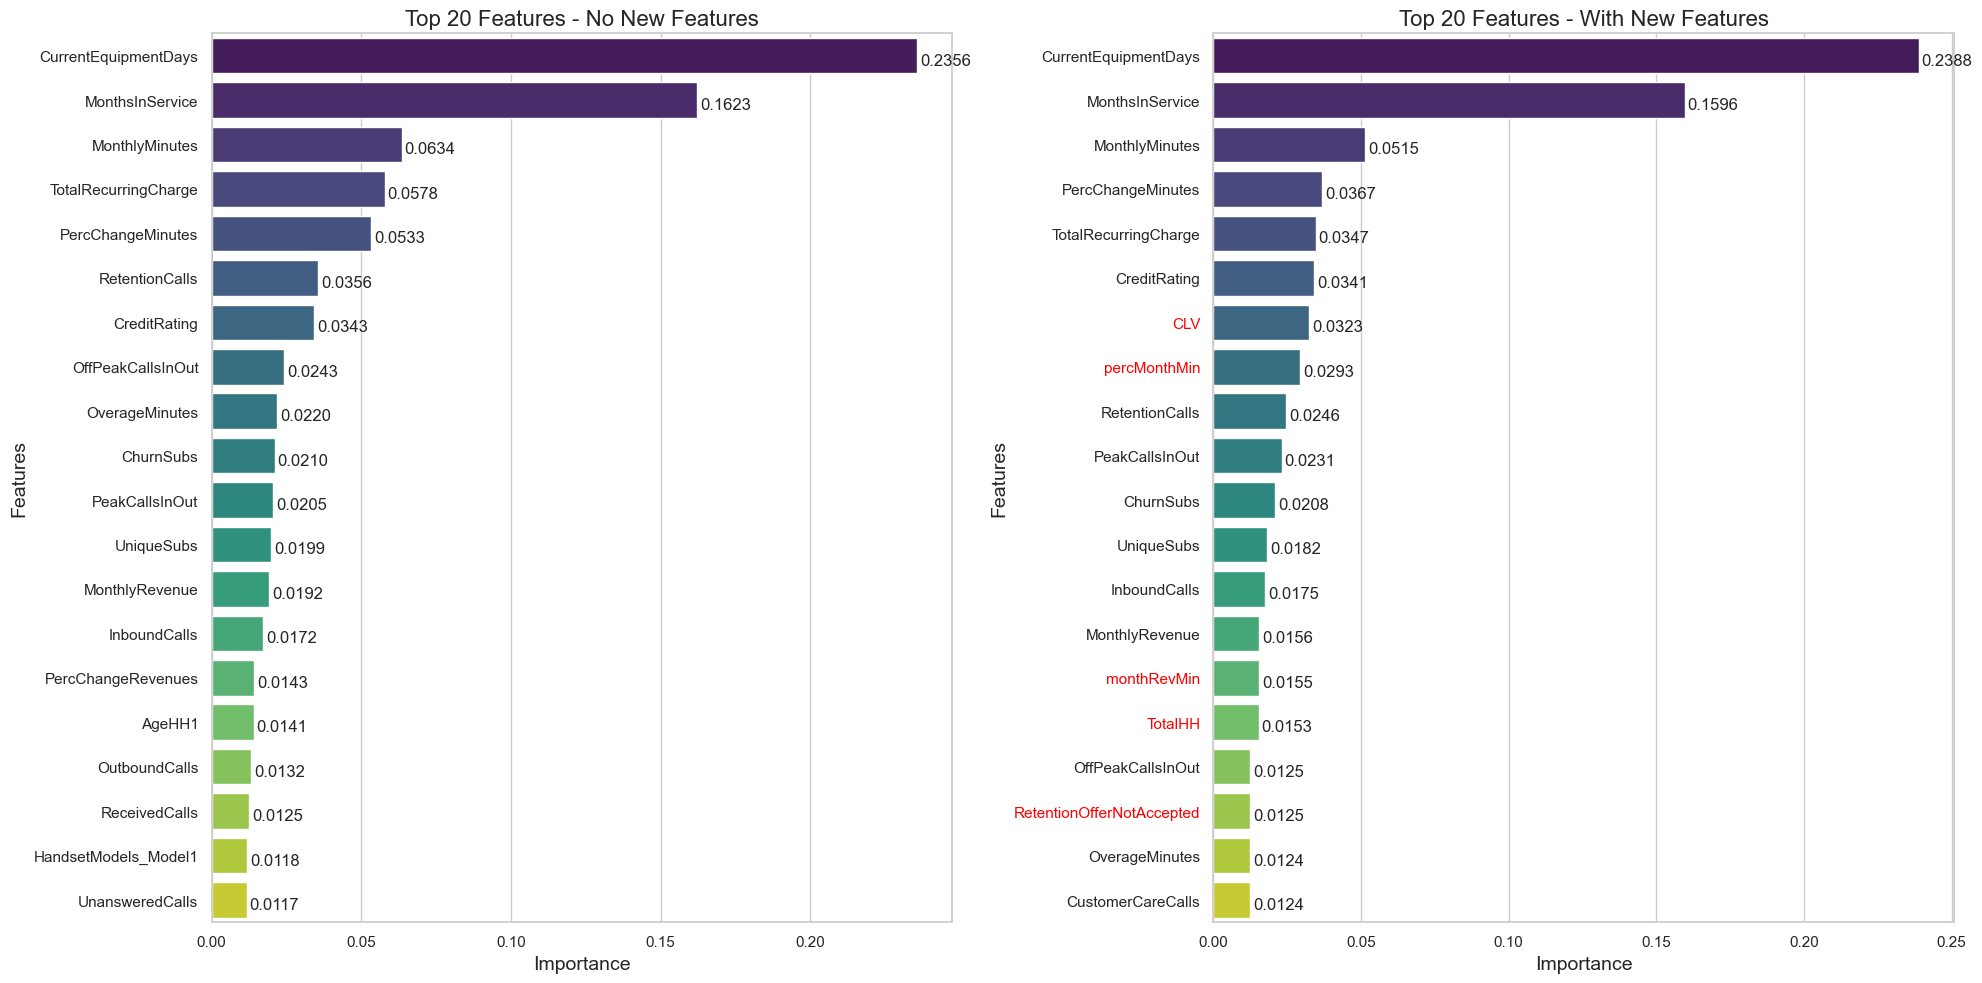

In [497]:
from sklearn.ensemble import RandomForestClassifier

# Train the RandomForest model on the dataset without new features
model_rf_no_new = RandomForestClassifier(class_weight="balanced", max_depth=5, random_state=0)
model_rf_no_new.fit(X_train_no_new_feature, y_train)

# Calculate the feature importances for the model without new features
importance_no_new = model_rf_no_new.feature_importances_
importances_no_new = pd.DataFrame({"Columns": X_train_no_new_feature.columns, "Importance": importance_no_new})
importances_no_new = importances_no_new.set_index("Columns")

# Train the RandomForest model on the dataset with new features
model_rf_new = RandomForestClassifier(class_weight="balanced", max_depth=5, random_state=0)
model_rf_new.fit(X_train, y_train)

# Calculate the feature importances for the model with new features
importance_new = model_rf_new.feature_importances_
importances_new = pd.DataFrame({"Columns": X_train.columns, "Importance": importance_new})
importances_new = importances_new.set_index("Columns")

# Set up the matplotlib figure and axes for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns

# Sort and plot top 20 features for the first dataset (without new features)
top_features_no_new = importances_no_new.sort_values(by="Importance", ascending=False).head(20)
sns.barplot(x="Importance", y=top_features_no_new.index, data=top_features_no_new, palette="viridis", ax=axes[0])
axes[0].set_title('Top 20 Features - No New Features', fontsize=16)
axes[0].set_xlabel('Importance', fontsize=14)
axes[0].set_ylabel('Features', fontsize=14)

# Annotate the first plot with feature importance values
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_width():.4f}', (p.get_width() + 0.001, p.get_y() + 0.5), va='center')

# List of specific features you want to highlight in red on the y-axis
highlight_features = ['CLV', 'monthRevMin', 'percMonthMin', 'TotalHH', 'RetentionOfferNotAccepted']

# Sort and plot top 20 features for the second dataset (with new features)
top_features_new = importances_new.sort_values(by="Importance", ascending=False).head(20)

# Plot the second barplot
sns.barplot(x="Importance", y=top_features_new.index, data=top_features_new, palette="viridis", ax=axes[1])
axes[1].set_title('Top 20 Features - With New Features', fontsize=16)
axes[1].set_xlabel('Importance', fontsize=14)
axes[1].set_ylabel('Features', fontsize=14)

# Annotate the second plot with feature importance values
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_width():.4f}', (p.get_width() + 0.001, p.get_y() + 0.5), va='center')

# Highlight specific feature names in red on the y-axis in the second plot
for tick_label in axes[1].get_yticklabels():
    if tick_label.get_text() in highlight_features:
        tick_label.set_color('red')

# Adjust the layout
plt.tight_layout()

# Show the comparison plots
plt.show()

In [498]:
# Create a list of outlier features based on importance from both DataFrames
feature_outlier_no_new = list(importances_no_new[importances_no_new["Importance"] < 0.002].index)
feature_outlier_new = list(importances_new[importances_new["Importance"] < 0.002].index)

# Combine both lists to get all outlier features
feature_outlier = list(set(feature_outlier_no_new + feature_outlier_new))

In [499]:
X_train.drop(feature_outlier,axis=1,inplace=True)
X_test.drop(feature_outlier,axis=1,inplace=True)
X_val.drop(feature_outlier,axis=1,inplace=True)

# CREATE MODEL
### Logistic regression to predict the risk of churn of each customer

In [500]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Create an instance of the model
logreg_model = LogisticRegression(class_weight='balanced')

# Fit the model to the training data
logreg_model.fit(X_train, y_train)

# Predict the probabilities of churn on the test set
y_pred_proba = logreg_model.predict_proba(X_test)

# The second column shows the predicted probabilities of churn
churn_proba = y_pred_proba[:, 1]

# Now calculate accuracy based on a threshold (e.g., 0.5)
y_pred_threshold = (churn_proba >= 0.5).astype(int)  # Apply threshold to classify
accuracy_lin = accuracy_score(y_test, y_pred_threshold)
print(f'Accuracy with Linear Regression: {accuracy_lin:.4f}')


Accuracy with Linear Regression: 0.5919


### Add probabilities to the train test to calculate the lift later 

In [501]:
y_pred_proba = logreg_model.predict_proba(X_train)
churn_proba = y_pred_proba[:, 1]
df_train_standart['Churn_Probability'] = churn_proba


### Random Forest to predict the churn risk with gridCV and cross validation

In [502]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [150],  # Number of trees 150
    'max_depth': [15],         # Maximum depth of each tree 15
    'min_samples_split': [2],  # Minimum number of samples required to split an internal node 2
    'min_samples_leaf': [1],    # Minimum number of samples required to be at a leaf node 1
    'class_weight': ['balanced']      # Handle class imbalance
}

# Initialize the Random Forest model
model_rf = RandomForestClassifier(random_state=0)

# Initialize GridSearchCV (set njobs=-1 for parallel processing)
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(f'Best Hyperparameters: {grid_search.best_params_}')

# Use the best model
best_rf_model = grid_search.best_estimator_


Fitting 5 folds for each of 1 candidates, totalling 5 fits


Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


### Now get the predicted probabilities of the tuned RandomForest Model 

In [503]:
# Get predicted probabilities
y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]  # Probability of class 1 (churn)

# If you want to calculate accuracy based on a threshold (e.g., 0.5)
y_pred_rf_threshold = (y_pred_proba_rf >= 0.5).astype(int)  # Apply threshold to classify
accuracy_rf = accuracy_score(y_test, y_pred_rf_threshold)
print(f'Accuracy with Tuned Random Forest: {accuracy_rf:.4f}')

Accuracy with Tuned Random Forest: 0.6903


### Cross-Validation to ensure accuracy of RandomForest model

In [430]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model_rf, X_train, y_train, cv=5, scoring='accuracy')

# Print mean and standard deviation of accuracy scores
print(f'Cross-validated accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

Cross-validated accuracy: 0.7192 ± 0.0016


### Create the XGBoost model similarly to the RandomForest

In [504]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100],  # Number of trees
    'max_depth': [5],     # Maximum depth of each tree
    'learning_rate': [0.1], # Step size shrinkage
    'min_child_weight': [1],    # Minimum sum of instance weight (hessian) needed in a child
    'scale_pos_weight': [1],     # Controls the balance of positive and negative weights
}

# Initialize the XGBoost model
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

# Initialize GridSearchCV (set n_jobs=-1 for parallel processing)
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(f'Best Hyperparameters: {grid_search.best_params_}')

# Use the best model
best_xgb_model = grid_search.best_estimator_

# Get predicted probabilities for churn risk
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]  # Probability of class 1 (churn)

# Optionally classify based on a threshold (e.g., 0.5)
y_pred_xgb_threshold = (y_pred_proba_xgb >= 0.5).astype(int)  # Apply threshold to classify

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb_threshold)
print(f'Accuracy with Tuned XGBoost: {accuracy_xgb:.4f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 1}
Accuracy with Tuned XGBoost: 0.7265


###  Calculating Metrics for Each Model and Comparison


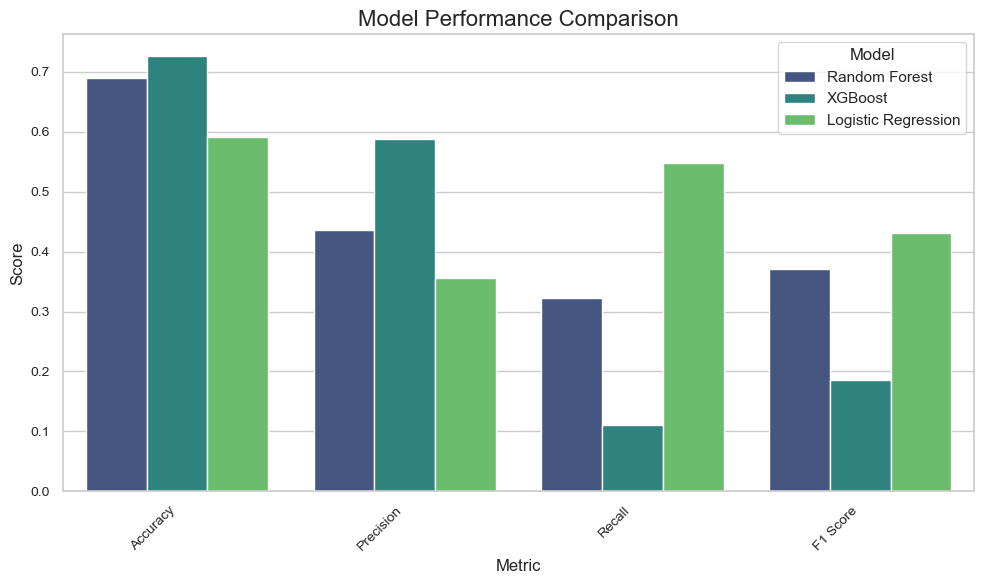

In [505]:
# Create a list of models and their predictions
models = {
    'Random Forest': best_rf_model.predict(X_test),
    'XGBoost': best_xgb_model.predict(X_test),
    'Logistic Regression': (logreg_model.predict(X_test) >= 0.5).astype(int)  # Thresholding
}

# Initialize a list to store metrics
metrics_list = []

# Calculate metrics for each model
for model_name, y_pred in models.items():
    metrics_list.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    })

# Convert the list of metrics into a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Melt the DataFrame for easier plotting
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Set the plot size
plt.figure(figsize=(10, 6))

# Create a barplot with seaborn
sns.barplot(x='Metric', y='Score', hue='Model', data=metrics_melted, palette='viridis')

# Customize the plot
plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Model')

# Show the plot
plt.tight_layout()
plt.show()

In [433]:
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.690417,0.436115,0.322749,0.370965
1,XGBoost,0.726537,0.588785,0.109909,0.185240
2,Logistic Regression,0.591829,0.354625,0.540475,0.428255


### ROC AUC evaluation

In [506]:
list_model=[logreg_model,best_rf_model,best_xgb_model]
list_model_name=["Logistic Regression","RandomForest","XGBoost"]

In [507]:
for i in range(len(list_model)):
    print(list_model_name[i])
    print("-"*50)
    print(classification_report(y_test,list_model[i].predict(X_test)))

Logistic Regression
--------------------------------------------------
              precision    recall  f1-score   support

       False       0.77      0.61      0.68      7267
        True       0.36      0.55      0.43      2866

    accuracy                           0.59     10133
   macro avg       0.56      0.58      0.56     10133
weighted avg       0.66      0.59      0.61     10133

RandomForest
--------------------------------------------------
              precision    recall  f1-score   support

       False       0.76      0.84      0.79      7267
        True       0.44      0.32      0.37      2866

    accuracy                           0.69     10133
   macro avg       0.60      0.58      0.58     10133
weighted avg       0.67      0.69      0.67     10133

XGBoost
--------------------------------------------------
              precision    recall  f1-score   support

       False       0.73      0.97      0.84      7267
        True       0.59      0.11      0.19

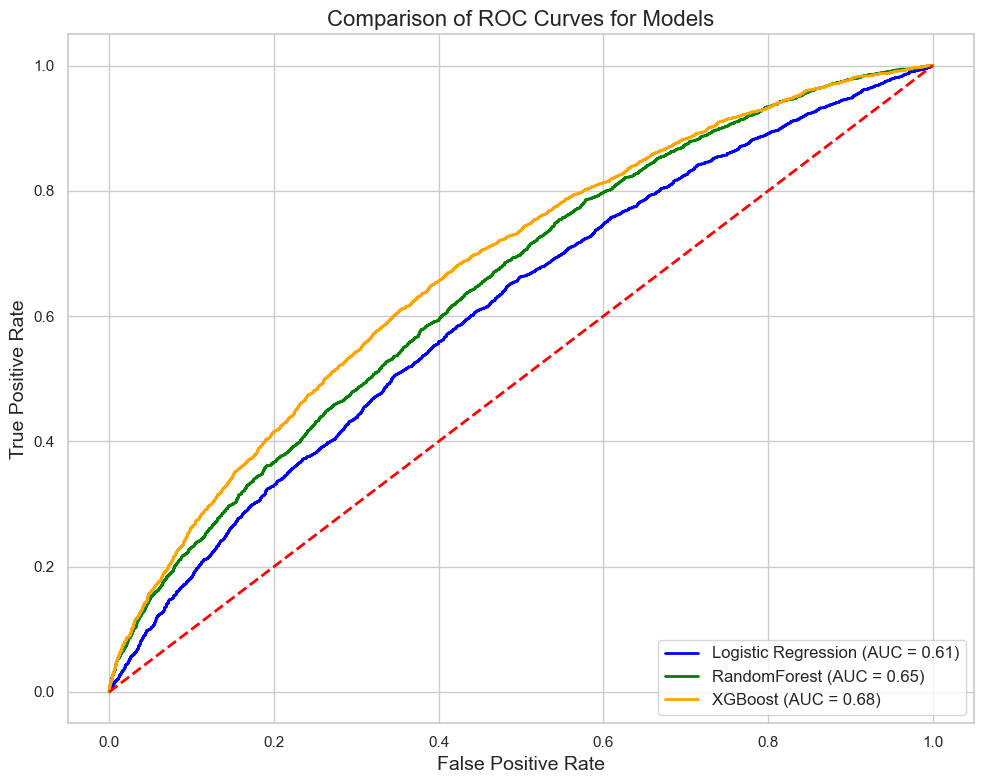

In [508]:
from sklearn.metrics import roc_curve, auc
# Define a dictionary to store the models and their AUC values
auc_dict = {}

# Set up the figure for a single plot
plt.figure(figsize=(10, 8))

# List of colors for the models
colors = ['blue', 'green', 'orange']

# Iterate over the models and plot their ROC curves
for count, (model_name, model) in enumerate(zip(list_model_name, list_model)):
    # Compute ROC curve and AUC for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # Plot ROC curve for the model
    plt.plot(fpr_test, tpr_test, color=colors[count], lw=2,
             label=f'{model_name} (AUC = {roc_auc_test:.2f})')
    
    # Store the AUC value in the dictionary
    auc_dict[model_name] = roc_auc_test

# Plot the diagonal reference line (random classifier) in red
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)

# Add title and labels
plt.title('Comparison of ROC Curves for Models', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)

# Add legend with model names and AUC values
plt.legend(loc="lower right", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

### Comparison and Evaluation:

After training both the stacking and boosting models, you can compare them using accuracy, precision, recall, and F1-score as you did with your individual models. Here’s a quick template to compare all models:

In [509]:
# Initialize an empty DataFrame for metrics
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Create a list of models and their predictions with the threshold set to 0.6
models = {
    'Random Forest': best_rf_model.predict_proba(X_test)[:, 1],  # Get probabilities for the positive class
    'XGBoost': best_xgb_model.predict_proba(X_test)[:, 1],       # Get probabilities for the positive class
    'Logistic Regression': logreg_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
}


threshold = 0.5

# Calculate metrics for each model
for model_name, y_probs in models.items():
    # Apply the threshold to get binary predictions
    y_pred = (y_probs >= threshold).astype(int)
    
    # Calculate metrics
    metrics_df = pd.concat([metrics_df, pd.DataFrame([{
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }])], ignore_index=True)

print(metrics_df)

                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.690319   0.435910  0.322749  0.370890
1              XGBoost  0.726537   0.588785  0.109909  0.185240
2  Logistic Regression  0.591927   0.356025  0.547453  0.431459


### Confusion matrices 

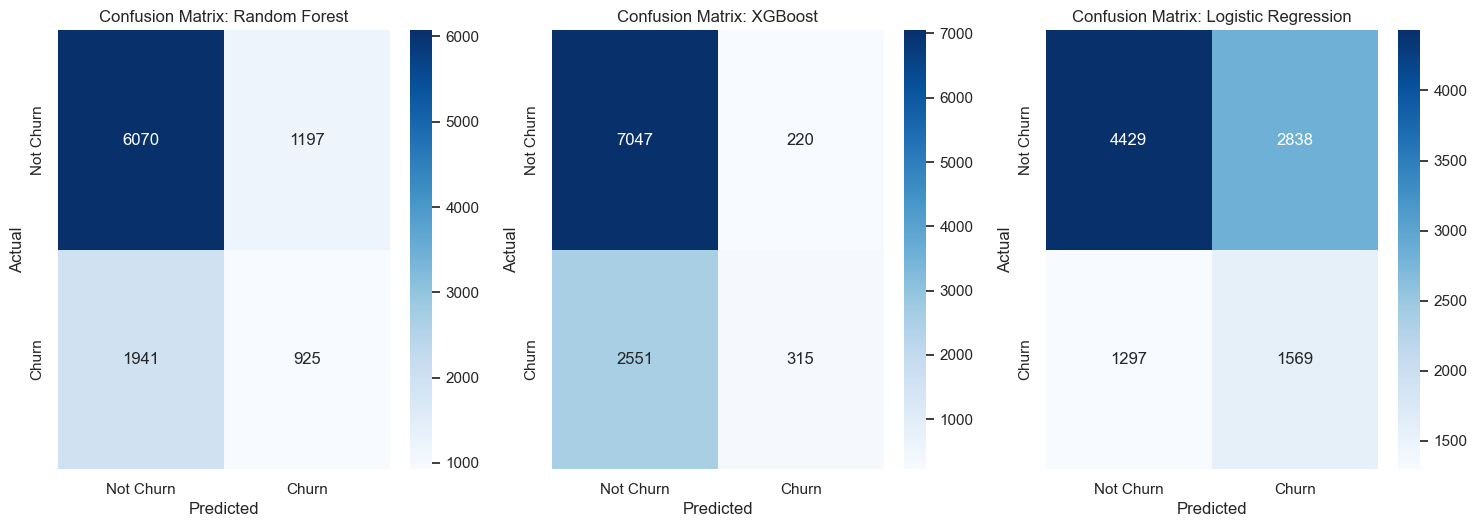

In [510]:
from sklearn.metrics import confusion_matrix
# Create a list of models and their predictions with the threshold set to 0.6
models = {
    'Random Forest': best_rf_model.predict_proba(X_test)[:, 1],
    'XGBoost': best_xgb_model.predict_proba(X_test)[:, 1],
    'Logistic Regression': logreg_model.predict_proba(X_test)[:, 1]
}

# Plot confusion matrices for each model
plt.figure(figsize=(15, 10))

for i, (model_name, proba) in enumerate(models.items()):
    # Apply the threshold to classify
    y_pred_threshold = (proba >= 0.5).astype(int)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_threshold)
    
    # Plot the confusion matrix
    plt.subplot(2, 3, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

### Make predictions with the logreg model on the holdout dataset

In [511]:
# Predict the probabilities of churn on the holdout set
y_pred_proba = logreg_model.predict_proba(X_val)

### Now add the predictions into the holdout for segmentation

In [513]:
# Extract the probabilities for the positive class (Churn_Yes)
churn_yes_prob = y_pred_proba[:, 1]  # This gives a 1D array of probabilities

# Add the Churn probability to the validation DataFrame
df_val_standart['Churn_Probability'] = churn_yes_prob

### Create the Risk Decile Column

In [514]:
# Create a new column for risk deciles in descending order
df_val_standart['riskDecile'] = pd.qcut(df_val_standart['Churn_Probability'], 
                                         q=10, 
                                         labels=[f'Decile {i+1}' for i in range(10)],
                                         duplicates='drop')

### Deciles based on CLV

In [515]:
# Create a new column for CLV deciles in descending order
df_val_standart['clvDecile'] = pd.qcut(df_val_standart['CLV'], 
                                        q=10, 
                                        labels=[f'Decile {i+1}' for i in range(10)],
                                        duplicates='drop')

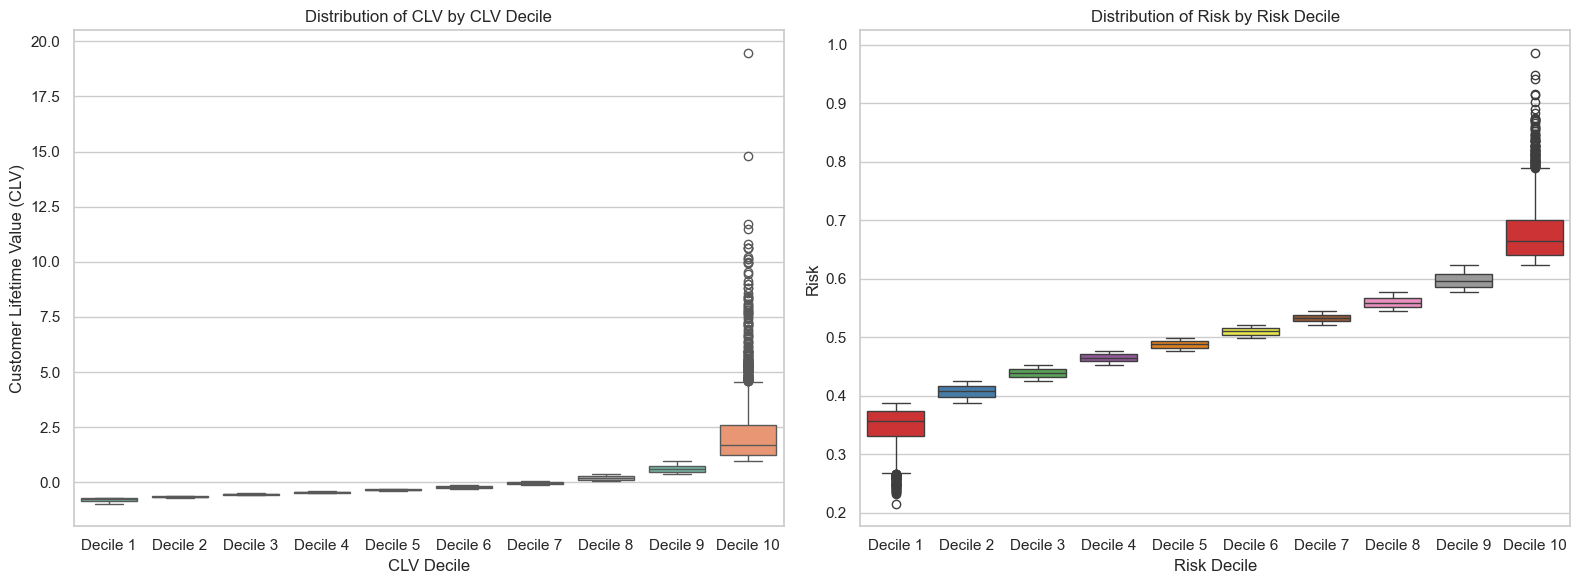

In [516]:

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Changed nrows to 1 and ncols to 2

# Plot for CLV distribution based on clvDecile
sns.boxplot(data=df_val_standart, x='clvDecile', y='CLV', ax=axes[0], palette="Set2")
axes[0].set_title('Distribution of CLV by CLV Decile')
axes[0].set_xlabel('CLV Decile')
axes[0].set_ylabel('Customer Lifetime Value (CLV)')

# Plot for risk distribution based on riskDecile
sns.boxplot(data=df_val_standart, x='riskDecile', y='Churn_Probability', ax=axes[1], palette="Set1")
axes[1].set_title('Distribution of Risk by Risk Decile')
axes[1].set_xlabel('Risk Decile')
axes[1].set_ylabel('Risk')

# Adjust the layout
plt.tight_layout()
plt.show()

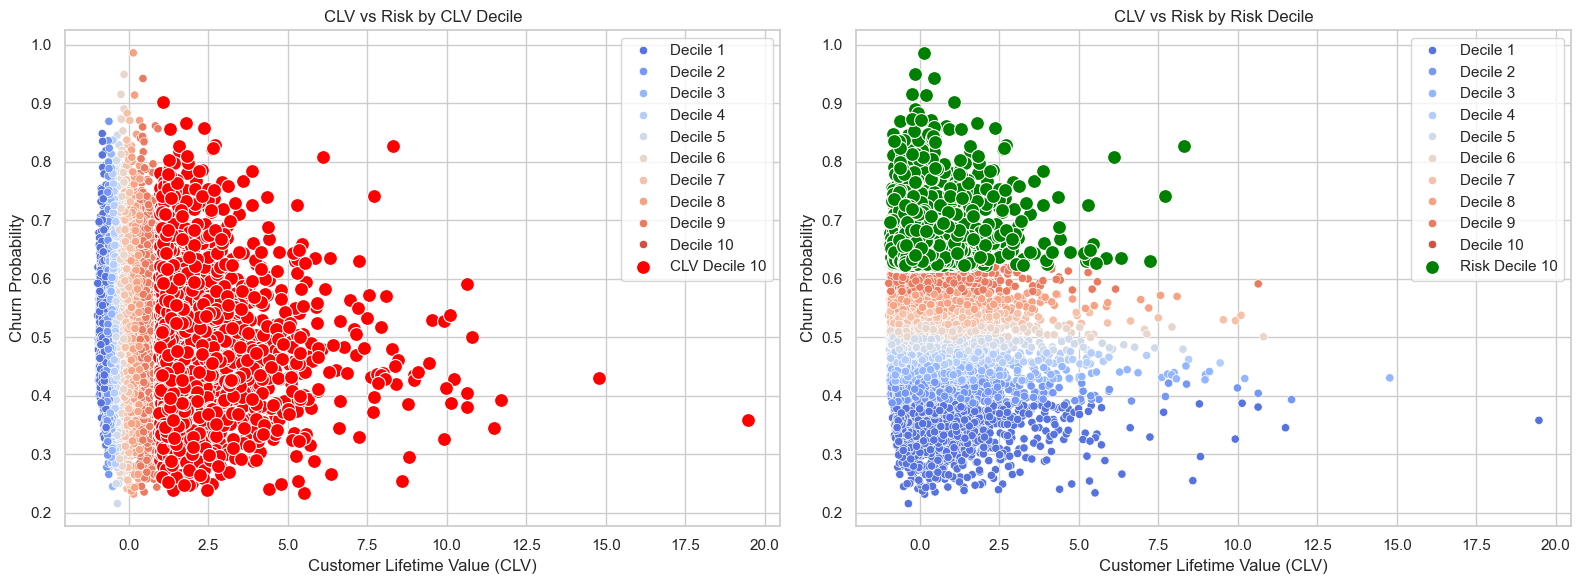

In [517]:

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# figure with subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Scatter plot for CLV vs Risk with color based on CLV Decile, highlighting Decile 10
sns.scatterplot(data=df_val_standart, x='CLV', y='Churn_Probability', hue='clvDecile', palette="coolwarm", ax=axes[0])
axes[0].set_title('CLV vs Risk by CLV Decile')
axes[0].set_xlabel('Customer Lifetime Value (CLV)')
axes[0].set_ylabel('Churn Probability')

# Highlight customers in Decile 10 for CLV
sns.scatterplot(data=df_val_standart[df_val_standart['clvDecile'] == 'Decile 10'], 
                x='CLV', y='Churn_Probability', color='red', s=100, label='CLV Decile 10', ax=axes[0])

# scatter plot for CLV vs Risk with color based on Risk Decile, highlighting Decile 10
sns.scatterplot(data=df_val_standart, x='CLV', y='Churn_Probability', hue='riskDecile', palette="coolwarm", ax=axes[1])
axes[1].set_title('CLV vs Risk by Risk Decile')
axes[1].set_xlabel('Customer Lifetime Value (CLV)')
axes[1].set_ylabel('Churn Probability')

# Highlight customers in Decile 10 for Risk
sns.scatterplot(data=df_val_standart[df_val_standart['riskDecile'] == 'Decile 10'], 
                x='CLV', y='Churn_Probability', color='green', s=100, label='Risk Decile 10', ax=axes[1])

# Adjust the layout
plt.tight_layout()
plt.show()

### Create both High Risk and High CLV top 10% segment 

In [518]:
import numpy as np

# Target number of rows
target_rows = 1985
# Initialize thresholds at 90th percentile
risk_percentile = 90
clv_percentile = 90

while True:
    # Calculate thresholds based on current percentiles
    risk_threshold = np.percentile(df_val_standart['Churn_Probability'], risk_percentile)
    clv_threshold = np.percentile(df_val_standart['CLV'], clv_percentile)

    # Filter customers in the top risk and CLV based on current thresholds
    intersect_segment = df_val_standart[
        (df_val_standart['Churn_Probability'] >= risk_threshold) & 
        (df_val_standart['CLV'] >= clv_threshold)
    ]

    # Check if the number of rows meets the target
    if intersect_segment.shape[0] >= target_rows:
        break
    else:
        # Decrease the percentiles to widen the selection
        risk_percentile -= 0.5
        clv_percentile -= 0.5

# Display the result
print(f'Number of customers in the intersect segment: {intersect_segment.shape[0]}')

Number of customers in the intersect segment: 1995


### Add the intersect segment identifier on the holdout set

In [519]:
# First, create a column 'Top10%_Intersect' initialized with 0 (for not in top 10%)
df_val_standart['HighRiskValue'] = 0

# Now, mark those who belong to the intersect segment with a 1
df_val_standart.loc[df_val_standart.index.isin(intersect_segment.index), 'HighRiskValue'] = 1

# Display the updated dataframe
print(df_val_standart[['HighRiskValue']].value_counts())

HighRiskValue
0                17866
1                 1995
Name: count, dtype: int64


In order to calculate the effectiveness of retention calls made for each segment we need to preserve the original holdout dataset before preprocessing

In [520]:
df_val_standart.head(10)

,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,...,Occupation_Student,MaritalStatus_No,MaritalStatus_Unknown,MaritalStatus_Yes,Churn_No,Churn_Yes,Churn_Probability,riskDecile,clvDecile,HighRiskValue
0,0.002426,-0.074562,-0.433157,-0.408059,-0.125684,-0.580592,2.208458,1.859157,0.424972,-0.469084,...,False,True,False,False,0,0,0.459886,Decile 4,Decile 10,0
1,-0.061185,0.102628,1.100186,-0.659523,-0.659755,-0.580592,0.267990,0.145043,0.639149,-0.550743,...,False,True,False,False,0,0,0.358684,Decile 1,Decile 10,0
2,1.124075,1.057826,0.136371,2.452343,2.315372,-0.580592,1.184183,1.859157,1.098100,0.075305,...,False,False,False,True,0,0,0.511357,Decile 6,Decile 10,0
3,-0.613988,-0.746663,-0.739825,-0.659523,-0.288227,-0.580592,0.222180,0.612820,-0.538824,-0.550743,...,False,True,False,False,0,0,0.502918,Decile 6,Decile 9,0
4,-0.060059,1.412207,0.136371,0.084810,-0.659755,2.027856,1.018123,0.209122,-0.431736,0.891888,...,False,True,False,False,0,0,0.341883,Decile 1,Decile 10,0
5,0.078423,1.841945,0.399230,-0.408059,-0.659755,-0.580592,-2.229351,-2.049663,2.826814,-0.741279,...,False,False,False,True,0,0,0.576529,Decile 9,Decile 10,1
6,-0.898270,-0.447273,-0.958874,-0.659523,-0.636535,-0.580592,-0.224464,0.113004,-0.538824,-0.550743,...,False,False,False,True,0,0,0.513617,Decile 6,Decile 8,0
7,-0.555724,0.921370,-0.476967,-0.408059,-0.543653,-0.580592,0.193549,0.036109,-0.232857,-0.741279,...,False,True,False,False,0,0,0.641576,Decile 10,Decile 9,1
8,-0.408798,-0.231386,-0.301727,-0.659523,0.594152,-0.580592,0.554300,0.375728,-0.737703,-0.278548,...,False,False,False,True,0,0,0.510628,Decile 6,Decile 9,0
9,2.916735,2.966696,2.874483,2.452343,2.315372,2.027856,1.218540,0.587188,0.685044,2.405970,...,False,False,True,False,0,0,0.430407,Decile 3,Decile 10,0


### EXTRA EDA ON 3 SEGMENTS

In [521]:
# Display the key statistics for the three subsets without ace_tools

# Defining key variables for comparison
key_variables = [
    'MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'OverageMinutes', 'DroppedCalls', 'Churn_Probability'
]

# Creating the subsets
clv_decile_10 = df_val_standart[df_val_standart['clvDecile'] == 'Decile 10']
risk_decile_10 = df_val_standart[df_val_standart['riskDecile'] == 'Decile 10']
high_risk_value = df_val_standart[df_val_standart['HighRiskValue'] == 1]

# Generating descriptive statistics for each subset
clv_stats = clv_decile_10[key_variables].describe()
risk_stats = risk_decile_10[key_variables].describe()
high_risk_value_stats = high_risk_value[key_variables].describe()

# Displaying the statistics for each group
clv_stats, risk_stats, high_risk_value_stats

(       MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  OverageMinutes  \
 count     1986.000000     1986.000000           1986.000000     1986.000000   
 mean         1.706779        1.168962              1.036920        1.152976   
 std          1.082439        1.212344              1.198757        1.280742   
 min         -0.504497       -1.058274             -2.054119       -0.659755   
 25%          0.767104        0.202425              0.136371       -0.381109   
 50%          1.536989        0.953956              1.012567        1.673905   
 75%          2.916735        2.082272              1.669714        2.315372   
 max          2.916735        2.966696              2.874483        2.315372   
 
        DroppedCalls  Churn_Probability  
 count   1986.000000        1986.000000  
 mean       0.799574           0.488309  
 std        1.241981           0.117041  
 min       -0.844792           0.233777  
 25%       -0.232857           0.402136  
 50%        0.486166      

In [522]:
df_retention['MadeCallToRetentionTeam'].value_counts()

MadeCallToRetentionTeam
No     19327
Yes      673
Name: count, dtype: int64

In [523]:
# Concatenating df_retention to df_val_standart along the columns

#df_merged = pd.concat([df_val_encoded, df_retention2[['RetentionOffersAccepted', 'RetentionCalls', 'CustomerID','MadeCallToRetentionTeam']]], axis=1)
df_merged = pd.concat([df_val_standart, df_retention[['RetentionOffersAccepted', 'RetentionCalls', 'CustomerID','MadeCallToRetentionTeam']]], axis=1)

In [ ]:
df_holdout.to_csv('df_holdouttest.csv', index=False)


In [524]:
# Keep only the first 19861 rows of df_merged
df_merged_trimmed = df_merged.iloc[:19861]

# Optional: Print the shape to confirm the number of rows
print("Number of rows in the trimmed DataFrame:", df_merged_trimmed.shape[0])

Number of rows in the trimmed DataFrame: 19861


In [525]:
df_final = df_merged_trimmed

### Calculate the average effectiveness of holdout set

In [526]:

# subset of only rows that made a retentioncall 
df_effectiveness = df_final[df_final['MadeCallToRetentionTeam'] == 'Yes']
# Calculate the total number of retention calls made
total_calls = df_effectiveness['RetentionCalls'].fillna(0).sum()

# Calculate the total number of retention offers accepted
total_accepted = df_effectiveness['RetentionOffersAccepted'].fillna(0).sum()

# Ensure both total_calls and total_accepted are scalar values
if isinstance(total_calls, pd.Series):
    total_calls = total_calls.sum()
if isinstance(total_accepted, pd.Series):
    total_accepted = total_accepted.sum()

# Calculate the retention effectiveness
# Ensure there's no division by zero
if total_calls > 0:
    retention_effectiveness = total_accepted / total_calls
else:
    retention_effectiveness = 0  # or np.nan, based on your preference

# Print the retention effectiveness
print("Retention calls effectiveness is {}".format(retention_effectiveness))

Retention calls effectiveness is 0.5048693918706237


In [527]:

# subset of only rows that made a retentioncall 
df_effectiveness = df_final[df_final['MadeCallToRetentionTeam'] == "Yes"]
# Subset data for those who received retention calls
df_highValue = df_effectiveness[df_effectiveness['clvDecile'] == 'Decile 10']
df_highRisk = df_effectiveness[df_effectiveness['riskDecile'] == 'Decile 10']
df_highRiskValue = df_effectiveness[df_effectiveness['HighRiskValue'] == 1]

# Calculate retention effectiveness
effectivenessHighValue = df_highValue['RetentionOffersAccepted'].sum() / df_highValue['RetentionCalls'].sum()
print(f"Effectiveness for highValue segment is {effectivenessHighValue}") #### 42/89
effectivenessHighRisk = df_highRisk['RetentionOffersAccepted'].sum() / df_highRisk['RetentionCalls'].sum()
print(f"Effectiveness for highValue segment is {effectivenessHighRisk}") ### 37/73
effectivenessHighRiskValue = df_highRiskValue['RetentionOffersAccepted'].sum() / df_highRiskValue['RetentionCalls'].sum()
print(f"Effectiveness for highValue segment is {effectivenessHighRiskValue}") ### 44/85

Effectiveness for highValue segment is RetentionCalls            NaN
RetentionCalls            NaN
RetentionOffersAccepted   NaN
RetentionOffersAccepted   NaN
dtype: float64
Effectiveness for highValue segment is RetentionCalls            NaN
RetentionCalls            NaN
RetentionOffersAccepted   NaN
RetentionOffersAccepted   NaN
dtype: float64
Effectiveness for highValue segment is RetentionCalls            NaN
RetentionCalls            NaN
RetentionOffersAccepted   NaN
RetentionOffersAccepted   NaN
dtype: float64


In [ ]:
df_highValue['RetentionOffersAccepted']

,RetentionOffersAccepted,RetentionOffersAccepted
5,-0.127984,0
134,6.899348,1
149,6.899348,1
161,6.899348,1
185,6.899348,1
...,...,...
19647,-0.127984,0
19675,-0.127984,0
19726,-0.127984,1
19754,-0.127984,0


In [ ]:
df

In [529]:
# Calculate total calls and total accepted for each segment

# High Value Segment
total_calls_highValue = df_highValue['RetentionCalls'].sum()
total_accepted_highValue = df_highValue['RetentionOffersAccepted'].sum()
print(f"Total Calls for High Value segment: {total_calls_highValue}")
print(f"Total Accepted for High Value segment: {total_accepted_highValue}")

# High Risk Segment
total_calls_highRisk = df_highRisk['RetentionCalls'].sum()
total_accepted_highRisk = df_highRisk['RetentionOffersAccepted'].sum()
print(f"Total Calls for High Risk segment: {total_calls_highRisk}")
print(f"Total Accepted for High Risk segment: {total_accepted_highRisk}")

# High Risk Value Segment
total_calls_highRiskValue = df_highRiskValue['RetentionCalls'].sum()
total_accepted_highRiskValue = df_highRiskValue['RetentionOffersAccepted'].sum()
print(f"Total Calls for High Risk Value segment: {total_calls_highRiskValue}")
print(f"Total Accepted for High Risk Value segment: {total_accepted_highRiskValue}")

Total Calls for High Value segment: RetentionCalls    40.298877
RetentionCalls    89.000000
dtype: float64
Total Accepted for High Value segment: RetentionOffersAccepted    45.467991
RetentionOffersAccepted    42.000000
dtype: float64
Total Calls for High Risk segment: RetentionCalls    118.025022
RetentionCalls     78.000000
dtype: float64
Total Accepted for High Risk segment: RetentionOffersAccepted    103.606405
RetentionOffersAccepted     42.000000
dtype: float64
Total Calls for High Risk Value segment: RetentionCalls    81.577029
RetentionCalls    85.000000
dtype: float64
Total Accepted for High Risk Value segment: RetentionOffersAccepted    88.527869
RetentionOffersAccepted    44.000000
dtype: float64


In [531]:
effectivenessHighValue = 42/89
print(f"Effectiveness for highValue segment is {effectivenessHighValue}") #### 42/89
effectivenessHighRisk = 42/78
print(f"Effectiveness for highRisk segment is {effectivenessHighRisk}") ### 37/73
effectivenessHighRiskValue = 44/85
print(f"Effectiveness for highValueRisk segment is {effectivenessHighRiskValue}") ### 44/85

Effectiveness for highValue segment is 0.47191011235955055
Effectiveness for highRisk segment is 0.5384615384615384
Effectiveness for highValueRisk segment is 0.5176470588235295


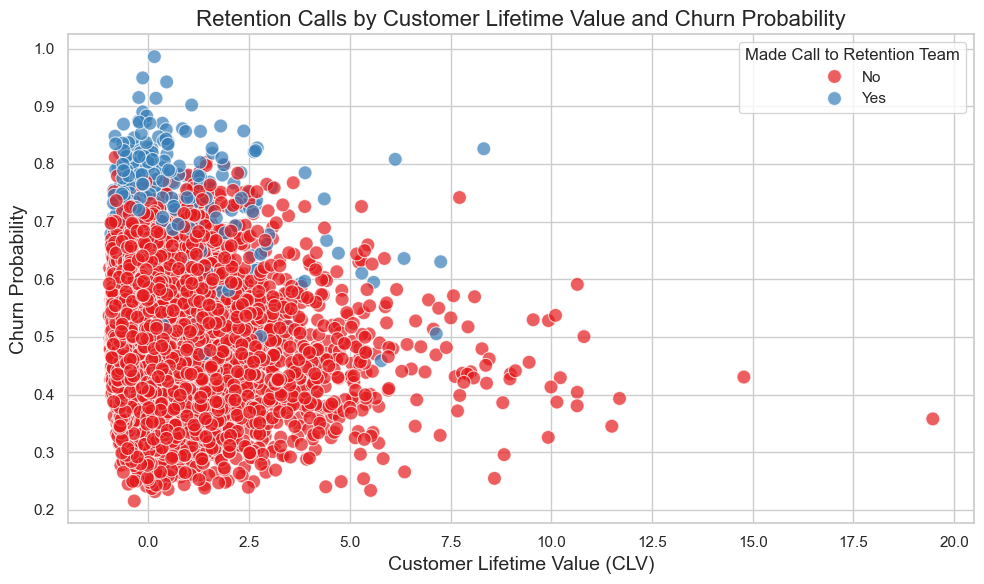

In [532]:
# Recreate the categorical column 'MadeCallToRetentionTeam' from one-hot encoding
df_val_standart['MadeCallToRetentionTeam'] = df_val_standart['MadeCallToRetentionTeam_Yes'].apply(lambda x: 'Yes' if x == 1 else 'No')

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define the scatter plot, using CLV on the x-axis and Churn_Probability on the y-axis, colored by MadeCallToRetentionTeam
plt.figure(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(
    data=df_val_standart,
    x='CLV',  # Assuming 'CLV' is the customer lifetime value column
    y='Churn_Probability',  # Assuming you have a column with churn probability
    hue='MadeCallToRetentionTeam',  # Color the points based on whether the customer received a call
    palette='Set1',  # Choose a color palette
    alpha=0.7,  # Make points slightly transparent to handle overlapping points
    s=100  # Size of points
)

# Adding titles and labels
plt.title('Retention Calls by Customer Lifetime Value and Churn Probability', fontsize=16)
plt.xlabel('Customer Lifetime Value (CLV)', fontsize=14)
plt.ylabel('Churn Probability', fontsize=14)

# Adjusting the layout for better visibility
plt.legend(title="Made Call to Retention Team")
plt.tight_layout()

# Show the plot
plt.show()

In [533]:
effectivenessHighValue = 50/100
print(f"Effectiveness for highValue segment is {effectivenessHighValue}") #### 42/89
effectivenessHighRisk = 48/104
print(f"Effectiveness for highRisk segment is {effectivenessHighRisk}") ### 37/73
effectivenessHighRiskValue = 57/127
print(f"Effectiveness for highValueRisk segment is {effectivenessHighRiskValue}") ### 44/85

Effectiveness for highValue segment is 0.5
Effectiveness for highRisk segment is 0.46153846153846156
Effectiveness for highValueRisk segment is 0.44881889763779526


### Calculate the lift of the High Risk Segment compared to the average 

In [534]:
# Create a new column for risk deciles in descending order
df_train_standart['riskDecile'] = pd.qcut(df_train_standart['Churn_Probability'], 
                                         q=10, 
                                         labels=[f'Decile {i+1}' for i in range(10)],
                                         duplicates='drop')
# Create a new column for CLV deciles in descending order
df_train_standart['clvDecile'] = pd.qcut(df_train_standart['CLV'], 
                                        q=10, 
                                        labels=[f'Decile {i+1}' for i in range(10)],
                                        duplicates='drop')
import numpy as np

# Target number of rows
target_rows = len(df_train_standart) / 10
# Initialize thresholds at 90th percentile
risk_percentile = 90
clv_percentile = 90

while True:
    # Calculate thresholds based on current percentiles
    risk_threshold = np.percentile(df_train_standart['Churn_Probability'], risk_percentile)
    clv_threshold = np.percentile(df_train_standart['CLV'], clv_percentile)

    # Filter customers in the top risk and CLV based on current thresholds
    intersect_segment = df_train_standart[
        (df_train_standart['Churn_Probability'] >= risk_threshold) & 
        (df_train_standart['CLV'] >= clv_threshold)
    ]

    # Check if the number of rows meets the target
    if intersect_segment.shape[0] >= target_rows:
        break
    else:
        # Decrease the percentiles to widen the selection
        risk_percentile -= 0.5
        clv_percentile -= 0.5

# Display the result
print(intersect_segment)
print(f'Number of customers in the intersect segment: {intersect_segment.shape[0]}')

# First, create a column 'Top10%_Intersect' initialized with 0 (for not in top 10%)
df_train_standart['HighRiskValue'] = 0

# Now, mark those who belong to the intersect segment with a 1
df_train_standart.loc[df_train_standart.index.isin(intersect_segment.index), 'HighRiskValue'] = 1

# Display the updated dataframe
print(df_train_standart[['HighRiskValue']].value_counts())

       MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
8            0.493869        0.037455              0.180181   
9            1.500116        0.330735              0.136371   
14           0.149634        0.070041              0.136371   
37           1.013740        0.013015             -0.739825   
39           0.621655       -0.341366              0.574469   
...               ...             ...                   ...   
40488        0.300501       -0.528740             -0.520776   
40489        0.034232        0.298148             -0.739825   
40499       -0.419775       -1.025687             -0.214108   
40511        1.764133        1.990621             -0.082678   
40516       -0.322106       -0.671307             -0.739825   

       DirectorAssistedCalls  OverageMinutes  RoamingCalls  PercChangeMinutes  \
8                  -0.659523        0.826357     -0.580592           2.208458   
9                  -0.156595        2.315372     -0.580592          -0.917334   


In [535]:

# Sort by predicted churn probabilities (highest to lowest)
df_train_standart = df_train_standart.sort_values('Churn_Probability', ascending=False)

# Create a binary outcome variable based on one-hot encoding
df_train_standart['ActualChurn'] = df_train_standart['Churn_Yes'].astype(int)

# Define the number of deciles
deciles = 10
df_train_standart['Decile'] = pd.qcut(df_train_standart['Churn_Probability'], q=deciles, labels=np.arange(1, deciles + 1))

# Calculate churners and total customers for each decile
cumulative_data = df_train_standart.groupby('Decile').agg({
    'ActualChurn': 'sum',  # Total churners in each decile
    'Churn_Yes': 'count'   # Total customers in each decile
}).reset_index()

# Rename columns for readability
cumulative_data.columns = ['Decile', 'Churners', 'TotalCustomers']

# Calculate response rate for each decile
cumulative_data['ResponseRate'] = cumulative_data['Churners'] / cumulative_data['TotalCustomers']

# Calculate average response rate across all customers
average_response_rate = df_train_standart['ActualChurn'].mean()

# Calculate lift for each decile
cumulative_data['Lift'] = cumulative_data['ResponseRate'] / average_response_rate

# Display the cumulative lift table
print(cumulative_data[['Decile', 'ResponseRate', 'Lift']])


  Decile  ResponseRate      Lift
0      1      0.167530  0.583971
1      2      0.192498  0.671001
2      3      0.232478  0.810363
3      4      0.256170  0.892947
4      5      0.272211  0.948864
5      6      0.289240  1.008222
6      7      0.320582  1.117475
7      8      0.333169  1.161348
8      9      0.365252  1.273181
9     10      0.439674  1.532601


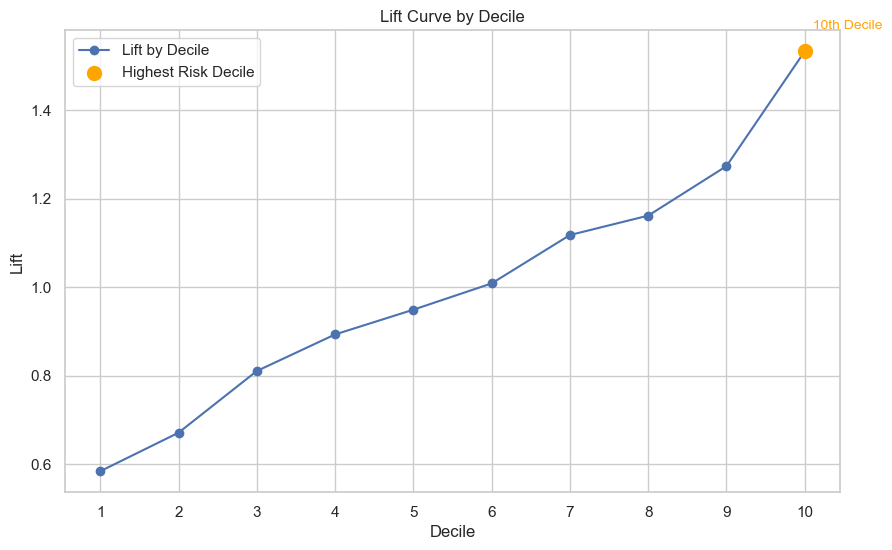

In [536]:

# Plot the lift curve
plt.figure(figsize=(10, 6))
plt.plot(cumulative_data['Decile'], cumulative_data['Lift'], marker='o', label='Lift by Decile')


# Highlight the 10th decile
plt.scatter(x=10, y=cumulative_data['Lift'][9], color='orange', s=100, label='Highest Risk Decile', zorder=5)

# Label the highlighted point
plt.text(10, cumulative_data['Lift'][9] + 0.05, '  10th Decile', color='orange', fontsize=10)

# Adding titles and labels
plt.title('Lift Curve by Decile')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.xticks(range(1, deciles + 1))  # Ensure x-axis shows integer decile labels from 1 to 10
plt.grid(True)
plt.legend()
plt.show()

### Now calculate Lift based on CLV Decile

In [537]:
# First, filter for the top decile (Decile 10)
top_decile = df_train_standart[df_train_standart['clvDecile'] == 'Decile 10']

# Calculate the number of churners in the top decile
churners_top_decile = top_decile['Churn_Yes'].sum()

# Calculate the total number of customers in the top decile
total_customers_top_decile = top_decile.shape[0]

# Calculate the response rate for the top decile
response_rate_top_decile = churners_top_decile / total_customers_top_decile if total_customers_top_decile > 0 else 0

# Calculate the overall response rate
overall_response_rate = df_train_standart['Churn_Yes'].sum() / df_train_standart.shape[0]

# Calculate the lift for the top decile
lift_top_decile = response_rate_top_decile / overall_response_rate if overall_response_rate > 0 else 0

# Display the results
print(f'Response Rate (Top Decile): {response_rate_top_decile:.4f}')
print(f'Overall Response Rate: {overall_response_rate:.4f}')
print(f'Lift (Top Decile): {lift_top_decile:.4f}')

Response Rate (Top Decile): 0.2605
Overall Response Rate: 0.2869
Lift (Top Decile): 0.9082


In [538]:
df_train_standart

,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,...,MaritalStatus_Unknown,MaritalStatus_Yes,Churn_No,Churn_Yes,Churn_Probability,riskDecile,clvDecile,HighRiskValue,ActualChurn,Decile
22392,0.290931,-1.058274,1.669714,-0.659523,-0.659755,-0.580592,0.050394,0.177083,-0.844792,-0.741279,...,True,False,False,True,1.000000,Decile 10,Decile 6,0,1,10
28873,0.735368,-0.473750,-0.739825,0.587738,2.315372,-0.580592,0.531395,-0.572642,2.016001,0.265841,...,True,False,False,True,0.980463,Decile 10,Decile 10,1,1,10
178,-0.168424,-0.514483,-0.301727,0.336274,0.152962,1.088815,-1.467050,-1.181392,-0.844792,-0.741279,...,True,False,False,True,0.971163,Decile 10,Decile 9,1,1,10
27842,-0.413583,-0.158066,-0.345537,-0.408059,0.524490,-0.580592,-1.438419,-0.027970,-0.737703,1.164083,...,True,False,False,True,0.942391,Decile 10,Decile 7,0,1,10
34696,-0.136337,1.385730,1.231616,2.452343,2.315372,-0.580592,-0.413428,-2.049663,0.333182,2.405970,...,True,False,False,True,0.940691,Decile 10,Decile 9,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40448,2.916735,2.966696,2.874483,2.452343,2.315372,-0.302357,0.657372,-2.049663,0.333182,2.405970,...,False,False,True,False,0.205296,Decile 1,Decile 10,0,0,1
4158,0.517512,2.966696,1.669714,-0.659523,-0.659755,-0.580592,-0.344714,0.125819,-0.186962,-0.469084,...,False,False,False,True,0.201518,Decile 1,Decile 6,0,1,1
8027,0.751975,1.748258,0.793518,1.332071,-0.659755,2.027856,-0.081308,-2.049663,-0.125769,2.405970,...,False,True,True,False,0.200363,Decile 1,Decile 10,0,0,1
19784,0.895524,2.966696,1.231616,2.452343,-0.357889,-0.580592,0.073299,-0.361181,-0.033979,2.405970,...,False,True,True,False,0.194573,Decile 1,Decile 8,0,0,1


### Calculate risk based on Intersect decile 

In [539]:
# First, filter for the top decile (Decile 10)
top_decile_riskValue = df_train_standart[df_train_standart['HighRiskValue'] == 1]

# Calculate the number of churners in the top decile
churners_top_decile_riskValue = top_decile_riskValue['Churn_Yes'].sum()

# Calculate the total number of customers in the top decile
total_customers_top_decile_riskValue = top_decile_riskValue.shape[0]

# Calculate the response rate for the top decile
response_rate_top_decile_riskValue = churners_top_decile_riskValue / total_customers_top_decile_riskValue if total_customers_top_decile_riskValue > 0 else 0

# Calculate the overall response rate
overall_response_rate = df_train_standart['Churn_Yes'].sum() / df_train_standart.shape[0]

# Calculate the lift for the top decile
lift_top_decile_riskValue = response_rate_top_decile_riskValue / overall_response_rate if overall_response_rate > 0 else 0

# Display the results
print(f'Response Rate (Top Decile): {response_rate_top_decile_riskValue:.4f}')
print(f'Overall Response Rate: {overall_response_rate:.4f}')
print(f'Lift (Top Decile): {lift_top_decile_riskValue:.4f}')

Response Rate (Top Decile): 0.3776
Overall Response Rate: 0.2869
Lift (Top Decile): 1.3163


### Plot the lift values of each segment

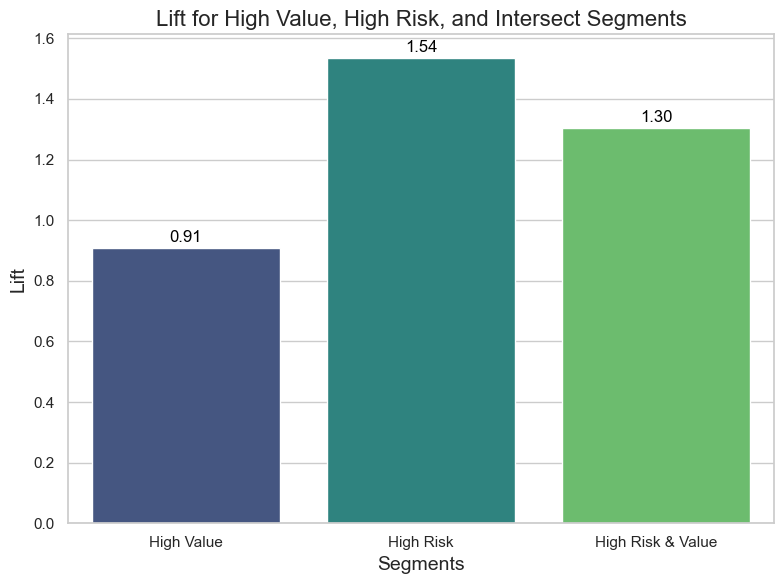

In [540]:
# Define the lift values for each segment
segments = ['High Value', 'High Risk', 'High Risk & Value']
lifts = [0.9082, 1.536041, 1.3039]  # The corresponding lift values

# Set up the plot style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(8, 6))
sns.barplot(x=segments, y=lifts, palette="viridis")

# Annotate bars with the exact lift values
for index, value in enumerate(lifts):
    plt.text(index, value + 0.02, f'{value:.2f}', color='black', ha="center", fontsize=12)

# Set titles and labels
plt.title('Lift for High Value, High Risk, and Intersect Segments', fontsize=16)
plt.xlabel('Segments', fontsize=14)
plt.ylabel('Lift', fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()

### Show it as a table in the Thesis 

### Now lets calculate the profits
in order to unstandardize the CLV we need to know the STD and Mean before the standardization of the train set.

In [541]:
df_train_missing.dropna(subset=['CLV'], inplace=True)
df_val_missing.dropna(subset=['CLV'])
## Retrieve the mean and scale used during the standardization
mean_clv = df_train_missing['CLV'].mean()
scale_clv = df_train_missing['CLV'].std()

mean_clv_val = df_val_missing['CLV'].mean()
scale_clv_val = df_val_missing['CLV'].std()

# Unstandardizing the CLV column
df_train_standart['OriginalCLV'] = (df_train_standart['CLV'] * scale_clv) + mean_clv
df_val_standart['OriginalCLV'] = (df_val_standart['CLV'] * scale_clv) + mean_clv

# Check the result
print(df_val_standart[['CLV', 'OriginalCLV']].head(55))

          CLV    OriginalCLV
0    1.871288   25270.686571
1    1.808258   24710.824636
2    3.757215   42022.276850
3    0.881933   16482.824257
4    1.566077   22559.677003
5    1.898522   25512.589626
6    0.197701   10405.186621
7    0.956575   17145.820720
8    0.920981   16829.667085
9   14.780698  139937.443584
10   1.648963   23295.903689
11   1.524405   22189.522946
12   1.659938   23393.387010
13   3.629458   40887.483094
14   3.338191   38300.329144
15   0.825106   15978.061589
16   2.372032   29718.500417
17   3.387975   38742.536090
18   0.363402   11877.012083
19   5.013475   53180.898980
20   0.641661   14348.630245
21   2.914908   34540.549748
22   0.016660    8797.104281
23  -0.082839    7913.318301
24   1.573270   22623.567037
25   5.857232   60675.498276
26   2.879491   34225.965893
27   0.931620   16924.167824
28   2.454829   30453.942214
29   1.551038   22426.088749
30   0.442682   12581.215263
31   0.909750   16729.907584
32   1.689310   23654.284398
33  -0.222322 

In [542]:
# Export df_val_standart to a CSV file
df_val_standart.to_csv("df_val_standart.csv", index=False)

### Formula for PRofit = Profit for each segment = Average CLV of the segment × (Number of customers in the segment × Effectiveness rate of the segment)

 
Formula in latex
\text{Profit per segment} = \text{Average CLV of segment} \times \left( \text{Number of Customers in segment} \times \text{Effectiveness Rate} \right)


### Lets calculate the Average CLV of each segment 

In [ ]:
# Calculate average CLV for High Risk segment
average_clv_highRisk = df_val_standart[df_val_standart['riskDecile'] == 'Decile 10']['OriginalCLV'].mean()

# Calculate average CLV for High Value segment
average_clv_highValue = df_val_standart[df_val_standart['clvDecile'] == 'Decile 10']['OriginalCLV'].mean()

# Calculate average CLV for High Risk Value segment
average_clv_highRiskValue = df_val_standart[df_val_standart['HighRiskValue'] == 1]['OriginalCLV'].mean()

# Print the results
print(f"Average CLV for High Risk segment: {average_clv_highRisk}")
print(f"Average CLV for High Value segment: {average_clv_highValue}")
print(f"Average CLV for High Risk Value segment: {average_clv_highRiskValue}")

Average CLV for High Risk segment: 10551.663944274109
Average CLV for High Value segment: 28578.924879717986
Average CLV for High Risk Value segment: 16510.918152177484


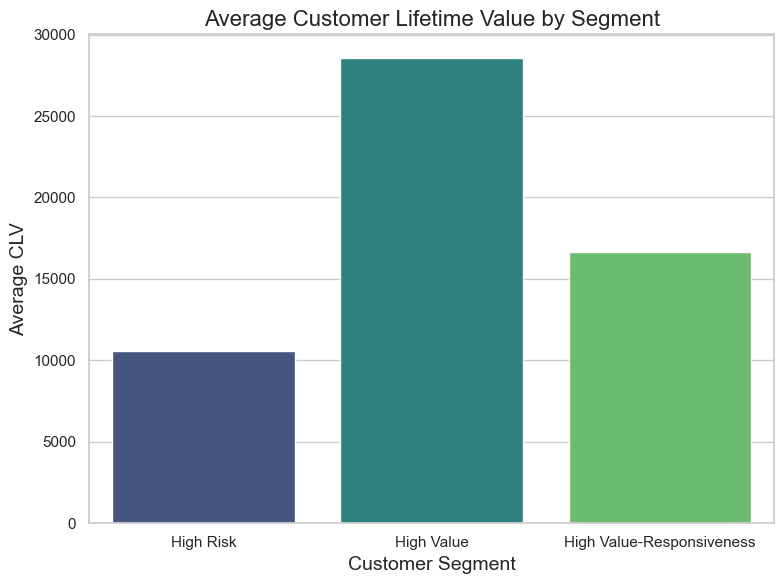

In [555]:
# Data for the segments
segments = ['High Risk', 'High Value', 'High Value-Responsiveness']
average_clv_highRespValue = 16623.729964285703

avg_clv = [average_clv_highRisk, average_clv_highValue, average_clv_highRespValue]

# Set up the plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Create bar plot
sns.barplot(x=segments, y=avg_clv, palette='viridis')

# Add labels
plt.title('Average Customer Lifetime Value by Segment', fontsize=16)
plt.xlabel('Customer Segment', fontsize=14)
plt.ylabel('Average CLV', fontsize=14)

# Adjust layout and show the plot without total labels
plt.tight_layout()
plt.show()

### Lets calculate the churn rate of each segment on the train standart set

In [ ]:
# Churn rate for the riskDecile == 'Decile 10'
# Filter data for riskDecile == 'Decile 10'
df_riskDecile_10 = df_train_standart[df_train_standart['riskDecile'] == 'Decile 10']

# Calculate churn rate for riskDecile 10
churn_rate_riskDecile_10 = df_riskDecile_10['Churn_Yes'].mean()
print(f"Churn rate for riskDecile 10: {churn_rate_riskDecile_10:.4f}")

# Churn rate for the clvDecile == 'Decile 10'
# Filter data for clvDecile == 'Decile 10'
df_clvDecile_10 = df_train_standart[df_train_standart['clvDecile'] == 'Decile 10']

# Calculate churn rate for clvDecile 10
churn_rate_clvDecile_10 = df_clvDecile_10['Churn_Yes'].mean()
print(f"Churn rate for clvDecile 10: {churn_rate_clvDecile_10:.4f}")

# Churn rate for the HighRiskValue == 1
# Filter data for HighRiskValue == 1
df_highRiskValue = df_train_standart[df_train_standart['HighRiskValue'] == 1]

# Calculate churn rate for HighRiskValue segment
churn_rate_highRiskValue = df_highRiskValue['Churn_Yes'].mean()
print(f"Churn rate for HighRiskValue segment: {churn_rate_highRiskValue:.4f}")

Churn rate for riskDecile 10: 0.4407
Churn rate for clvDecile 10: 0.2605
Churn rate for HighRiskValue segment: 0.3741


### Calculate the profits without using the churn rate

In [557]:
# Calculate the number of customers in each segment
num_customers_highRisk = len(df_val_standart[df_val_standart['riskDecile'] == 'Decile 10'])
num_customers_highValue = len(df_val_standart[df_val_standart['clvDecile'] == 'Decile 10'])
num_customers_highRiskValue = len(df_val_standart[df_val_standart['HighRiskValue'] == 1])


# Calculate expected profit for each segment
profit_highRisk = average_clv_highRisk * (num_customers_highRisk * 1.55 )
profit_highValue = average_clv_highValue * (num_customers_highValue * 0.9)
profit_highRiskValue = average_clv_highRespValue * (num_customers_highRiskValue * 1.31)

# Print the expected profits
print(f"Expected Profit for High Risk segment: {profit_highRisk:.2f}")
print(f"Expected Profit for High Value segment: {profit_highValue:.2f}")
print(f"Expected Profit for High Risk Value segment: {profit_highRiskValue:.2f}")

Expected Profit for High Risk segment: 32481187.12
Expected Profit for High Value segment: 51081970.33
Expected Profit for High Risk Value segment: 43445287.08


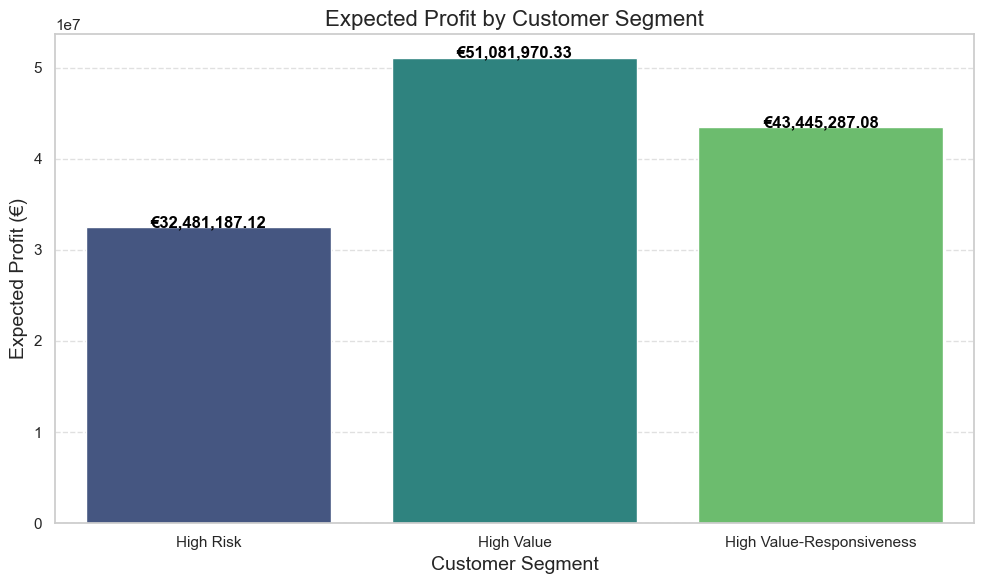

In [558]:
# Define the segments and their respective profits
segments = ['High Risk', 'High Value', 'High Value-Responsiveness']
profits = [profit_highRisk, profit_highValue, profit_highRiskValue]

# Set the plot style and size
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a bar plot for expected profits
barplot = sns.barplot(x=segments, y=profits, palette="viridis")

# Add labels and title
barplot.set_title('Expected Profit by Customer Segment', fontsize=16)
barplot.set_xlabel('Customer Segment', fontsize=14)
barplot.set_ylabel('Expected Profit (€)', fontsize=14)

# Annotate bars with the exact profit values
for index, value in enumerate(profits):
    barplot.text(index, value + 1000, f'€{value:,.2f}', color='black', ha="center", fontsize=12, fontweight='bold')

# Adding grid and ensuring layout fits well
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

### 2. Use Churn Rate for Adjusting Profit:

	•	Reason: If a segment has a high churn rate, retaining a customer from that segment is more valuable.	
	•	Approach: Multiply the expected profit by the churn rate of each segment:

Adjusted Profit = Average CLV * (Churn Rate of segment * Number of Customers * effectiveness rate)


In [561]:

# Calculate adjusted profit for each segment
profit_highRisk_adjusted = average_clv_highRisk * (num_customers_highRisk * 0.53 *  1.55)
profit_highValue_adjusted = average_clv_highValue * (num_customers_highValue * 0.45 * 0.9)
profit_highRiskValue_adjusted = 16623 * (num_customers_highRiskValue * 0.68 * 1.07)

# Print adjusted profits
print(f"Adjusted Profit for High Risk segment: {profit_highRisk_adjusted:.2f}")
print(f"Adjusted Profit for High Value segment: {profit_highValue_adjusted:.2f}")
print(f"Adjusted Profit for High Risk Value segment: {profit_highRiskValue_adjusted:.2f}")

Adjusted Profit for High Risk segment: 17215029.17
Adjusted Profit for High Value segment: 22986886.65
Adjusted Profit for High Risk Value segment: 24129315.13


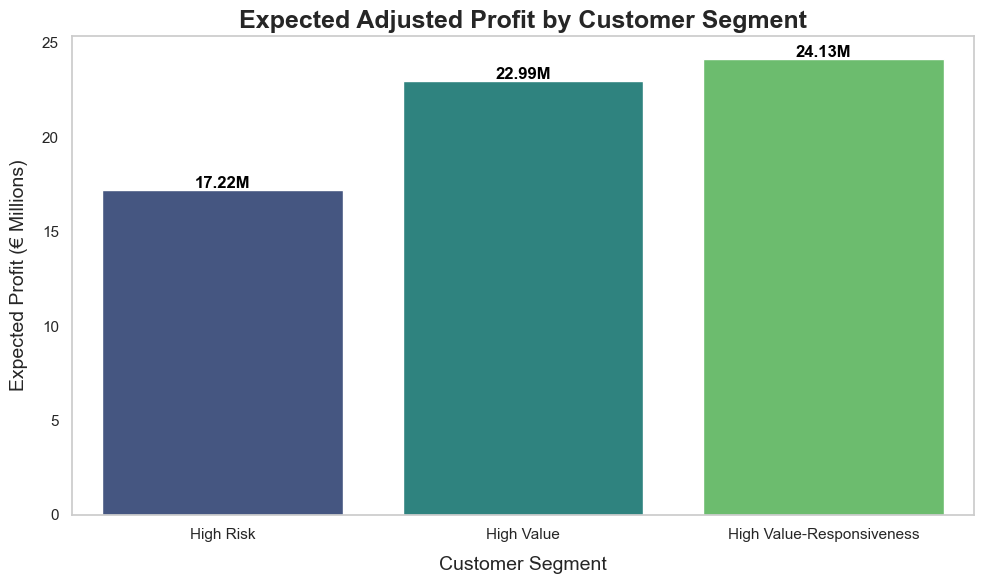

In [562]:

# Define the adjusted profits and the segments
segments = ['High Risk', 'High Value', 'High Value-Responsiveness']
adj_profits = [profit_highRisk_adjusted / 1e6, profit_highValue_adjusted / 1e6, profit_highRiskValue_adjusted / 1e6]  # Convert to millions

# Set the style of the plots
sns.set(style="whitegrid", rc={"axes.grid": False})  # No grid in background for a cleaner look

# Set up figure and axis
plt.figure(figsize=(10, 6))

# Create a barplot with new scientific styling
barplot = sns.barplot(x=segments, y=adj_profits, palette="viridis")

# Add title and labels
barplot.set_title('Expected Adjusted Profit by Customer Segment', fontsize=18, fontweight='bold')
barplot.set_xlabel('Customer Segment', fontsize=14, labelpad=10)
barplot.set_ylabel('Expected Profit (€ Millions)', fontsize=14, labelpad=10)

# Annotate bars with the exact profit values in millions
for index, value in enumerate(adj_profits):
    barplot.text(index, value + 0.1, f'{value:.2f}M', color='black', ha="center", fontsize=12, fontweight='bold')

# Ensure layout is clean and spacing fits well
plt.tight_layout()

# Show the final plot
plt.show()

### Plot Profit and Adjusted together 


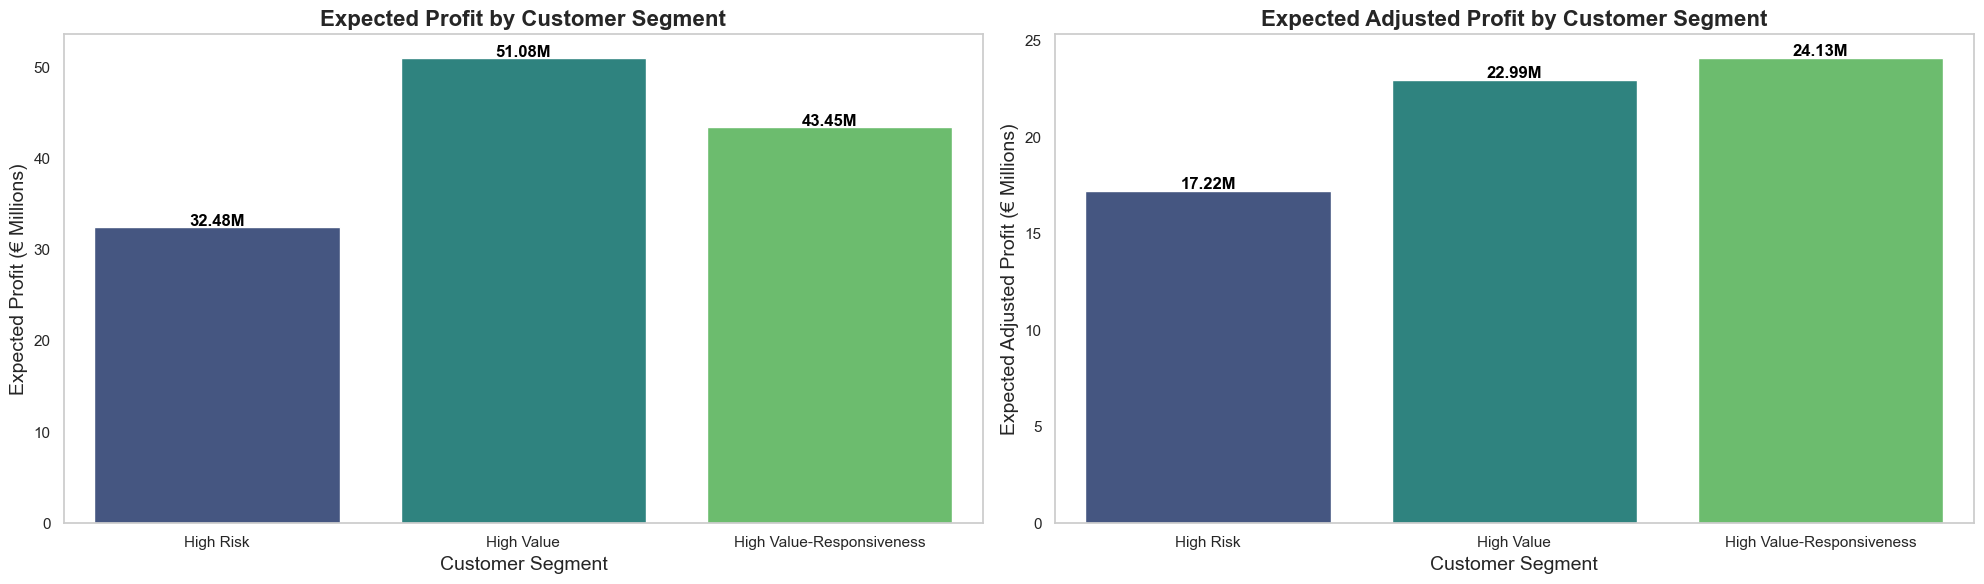

In [563]:

# Define the segments and their respective profits
segments = ['High Risk', 'High Value', 'High Value-Responsiveness']
profits = [profit_highRisk / 1e6, profit_highValue / 1e6, profit_highRiskValue / 1e6]  # Convert to millions
adj_profits = [profit_highRisk_adjusted / 1e6, profit_highValue_adjusted / 1e6, profit_highRiskValue_adjusted / 1e6]  # Convert to millions

# Set up a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

# Plot for Expected Profit
sns.set(style="whitegrid")
sns.barplot(x=segments, y=profits, palette="viridis", ax=axes[0])
axes[0].set_title('Expected Profit by Customer Segment', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Customer Segment', fontsize=14)
axes[0].set_ylabel('Expected Profit (€ Millions)', fontsize=14)

# Annotate bars with the exact profit values in millions for Expected Profit
for index, value in enumerate(profits):
    axes[0].text(index, value + 0.1, f'{value:.2f}M', color='black', ha="center", fontsize=12, fontweight='bold')

# Plot for Adjusted Profit
sns.barplot(x=segments, y=adj_profits, palette="viridis", ax=axes[1])
axes[1].set_title('Expected Adjusted Profit by Customer Segment', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Customer Segment', fontsize=14)
axes[1].set_ylabel('Expected Adjusted Profit (€ Millions)', fontsize=14)

# Annotate bars with the exact profit values in millions for Adjusted Profit
for index, value in enumerate(adj_profits):
    axes[1].text(index, value + 0.1, f'{value:.2f}M', color='black', ha="center", fontsize=12, fontweight='bold')

# Adjust the layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

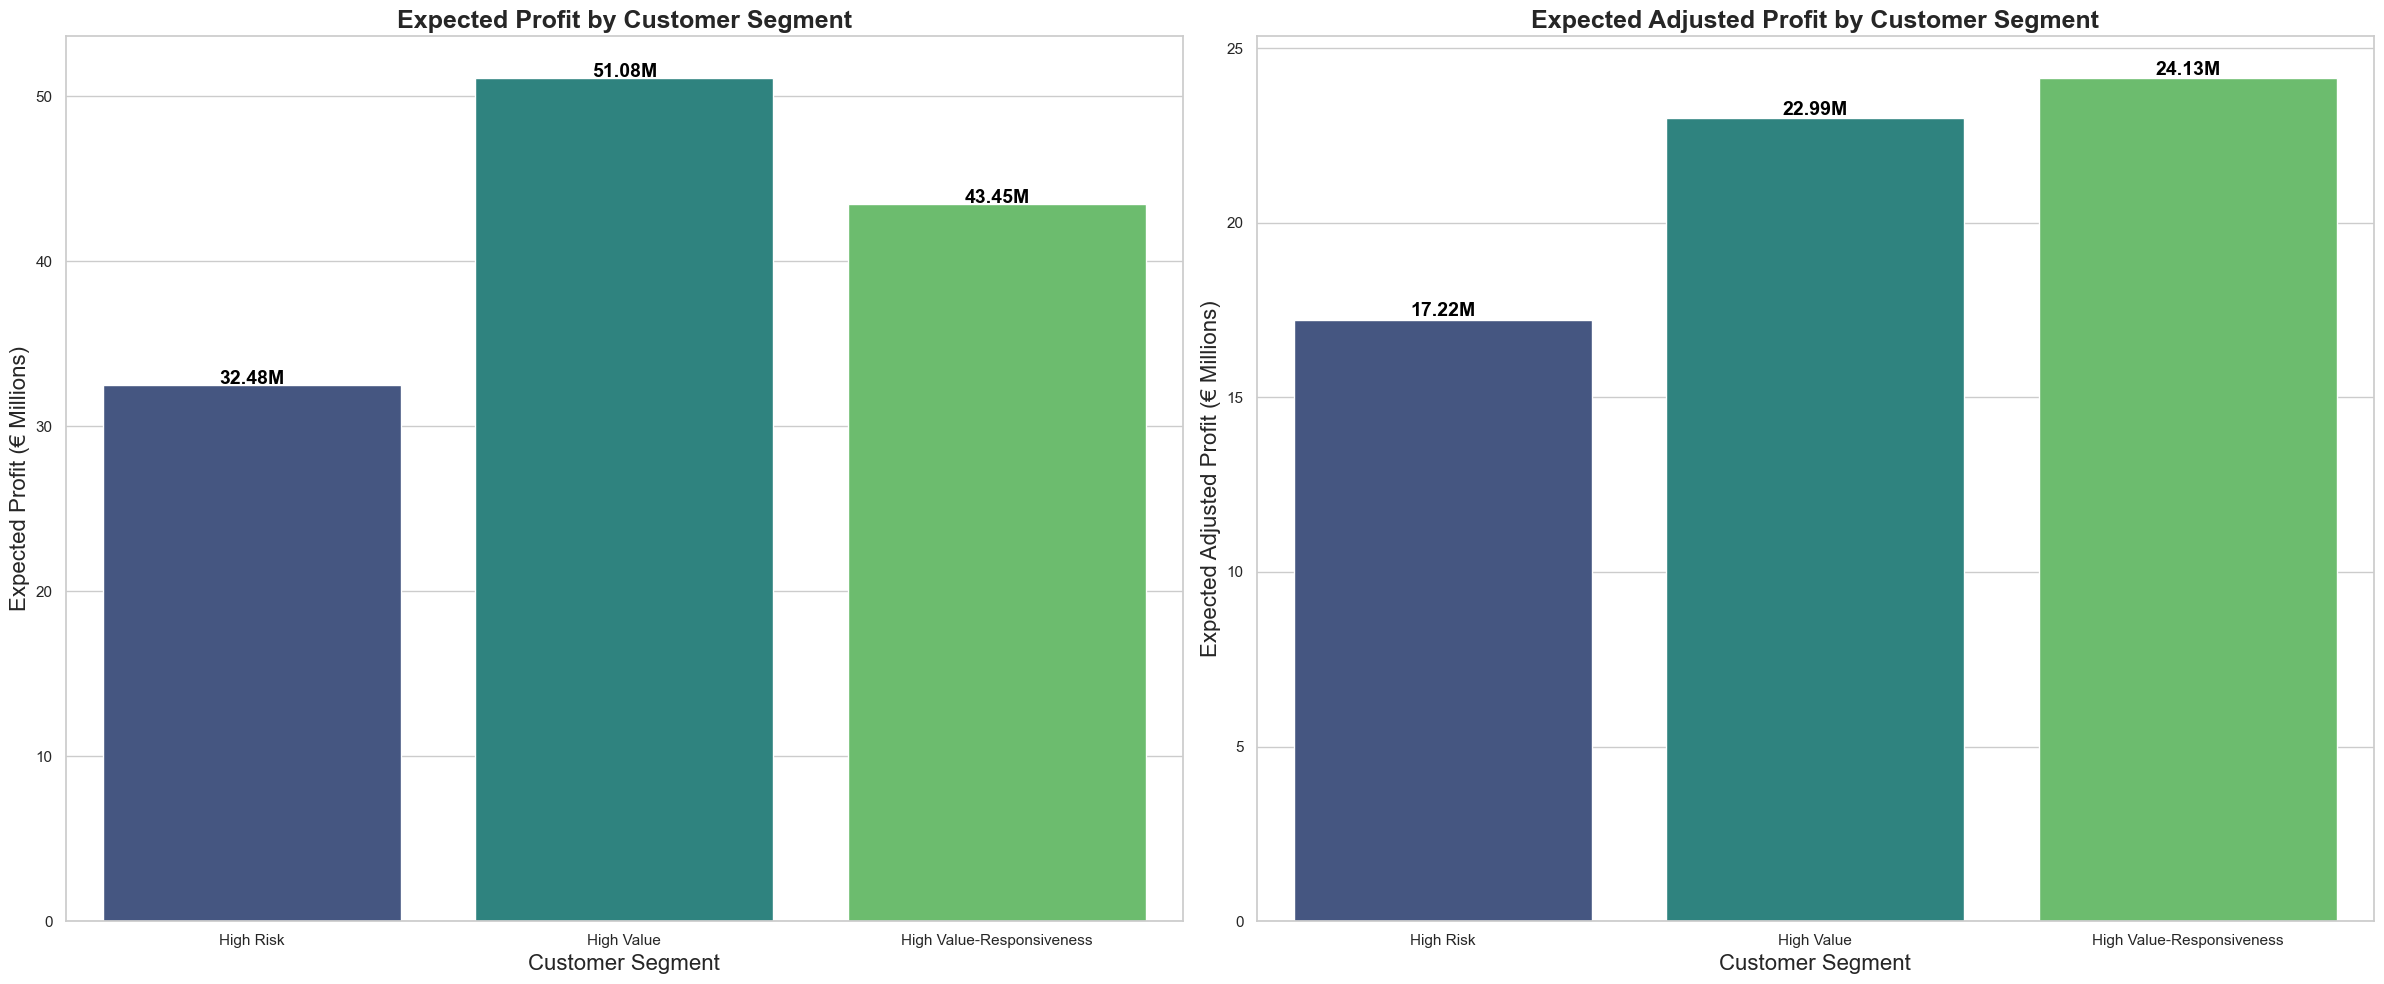

In [564]:
# Define the segments and their respective profits
segments = ['High Risk', 'High Value', 'High Value-Responsiveness']
profits = [profit_highRisk / 1e6, profit_highValue / 1e6, profit_highRiskValue / 1e6]  # Convert to millions
adj_profits = [profit_highRisk_adjusted / 1e6, profit_highValue_adjusted / 1e6, profit_highRiskValue_adjusted / 1e6]  # Convert to millions

# Set up a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 10))  # Larger size for better export

# Plot for Expected Profit
sns.set(style="whitegrid")
sns.barplot(x=segments, y=profits, palette="viridis", ax=axes[0])
axes[0].set_title('Expected Profit by Customer Segment', fontsize=18, fontweight='bold')
axes[0].set_xlabel('Customer Segment', fontsize=16)
axes[0].set_ylabel('Expected Profit (€ Millions)', fontsize=16)

# Annotate bars with the exact profit values in millions for Expected Profit
for index, value in enumerate(profits):
    axes[0].text(index, value + 0.1, f'{value:.2f}M', color='black', ha="center", fontsize=14, fontweight='bold')

# Plot for Adjusted Profit
sns.barplot(x=segments, y=adj_profits, palette="viridis", ax=axes[1])
axes[1].set_title('Expected Adjusted Profit by Customer Segment', fontsize=18, fontweight='bold')
axes[1].set_xlabel('Customer Segment', fontsize=16)
axes[1].set_ylabel('Expected Adjusted Profit (€ Millions)', fontsize=16)

# Annotate bars with the exact profit values in millions for Adjusted Profit
for index, value in enumerate(adj_profits):
    axes[1].text(index, value + 0.1, f'{value:.2f}M', color='black', ha="center", fontsize=14, fontweight='bold')

# Adjust the layout for better spacing
plt.tight_layout()

# Save the figure as a high-res (dpi=300) PNG image for Overleaf
plt.savefig('customer_segment_profits.png', dpi=300)

# Show the plots
plt.show()